In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
root = '/content/drive/MyDrive/Marino_Matrella'
# os.chdir(root)


Mounted at /content/drive/


# Init

In [ ]:
!pip install tensorflow_addons
!pip install spec_augment
!pip install git+https://github.com/keras-team/keras-cv.git tensorflow --upgrade

  Cloning https://github.com/keras-team/keras-cv.git to /tmp/pip-req-build-8tklzidy
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-cv.git /tmp/pip-req-build-8tklzidy
  Resolved https://github.com/keras-team/keras-cv.git to commit f05494c1057c95cbf44abac3238afcf262a50431
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
%run "/content/drive/MyDrive/Marino_Matrella/Utilities.ipynb"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/.shortcut-targets-by-id/1pfBa0fnatsy0qYLtZ2wpGwzSR-zOPP2W/CIDL project
tensor version is  2.14.0-dev20230629


In [ ]:
import os
import sys
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import image_dataset_from_directory
from spec_augment import SpecAugment
import tensorflow_addons as tfa
from tensorflow import keras
from sklearn import metrics
import keras_cv

In [ ]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

MODEL_FOLDER = os.path.join(root, 'birds/model/VGG16/')
MODEL_FOLDER
IMG_SIZE = 224
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

# Spectrograms augmentation (specaug) balanced dataset

In [ ]:
PATH = os.path.join(root,'birds/dataset')
train_path = os.path.join(PATH, 'train_specaug')
test_path = os.path.join(PATH, 'test')
validation_path  = os.path.join(PATH, 'validation')

train_set = image_dataset_from_directory(
    train_path,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    labels="inferred",
    shuffle=True,
    color_mode='rgb')

test_set = image_dataset_from_directory(
    test_path,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    labels="inferred",
    shuffle=False,
    color_mode='rgb')

validation_set = image_dataset_from_directory(
    validation_path,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    labels="inferred",
    shuffle=True,
    color_mode='rgb')

Found 10000 files belonging to 100 classes.
Found 5306 files belonging to 100 classes.
Found 7983 files belonging to 100 classes.


# Spectrogram augmentation balanced dataset

In [ ]:
PATH = os.path.join(root,'birds/dataset')
train_path = os.path.join(PATH, 'train_aug_spec')
test_path = os.path.join(PATH, 'test')
validation_path  = os.path.join(PATH, 'validation')

train_set = image_dataset_from_directory(
    train_path,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    labels="inferred",
    shuffle=True,
    color_mode='rgb')

test_set = image_dataset_from_directory(
    test_path,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    labels="inferred",
    shuffle=False,
    color_mode='rgb')

validation_set = image_dataset_from_directory(
    validation_path,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    labels="inferred",
    shuffle=True,
    color_mode='rgb')

Found 10000 files belonging to 100 classes.
Found 5306 files belonging to 100 classes.
Found 7983 files belonging to 100 classes.


# Audio augmentation balanced dataset

In [ ]:
PATH = os.path.join(root,'birds/dataset')
train_path = os.path.join(PATH, 'train_audio_aug')
test_path = os.path.join(PATH, 'test')
validation_path  = os.path.join(PATH, 'validation')

train_set = image_dataset_from_directory(
    train_path,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    labels="inferred",
    shuffle=True,
    color_mode='rgb')

test_set = image_dataset_from_directory(
    test_path,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    labels="inferred",
    shuffle=False,
    color_mode='rgb')

validation_set = image_dataset_from_directory(
    validation_path,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    labels="inferred",
    shuffle=True,
    color_mode='rgb')

Found 10000 files belonging to 100 classes.
Found 5306 files belonging to 100 classes.
Found 7983 files belonging to 100 classes.


In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Unbalanced

In [ ]:
PATH = os.path.join(root,'birds/dataset')
train_path = os.path.join(PATH, 'train')
test_path = os.path.join(PATH, 'test')
validation_path  = os.path.join(PATH, 'validation')

train_set = image_dataset_from_directory(
    train_path,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    labels="inferred",
    shuffle=True,
    color_mode='rgb')

test_set = image_dataset_from_directory(
    test_path,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    labels="inferred",
    shuffle=False,
    color_mode='rgb')

validation_set = image_dataset_from_directory(
    validation_path,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    labels="inferred",
    shuffle=True,
    color_mode='rgb')

Found 9959 files belonging to 100 classes.
Found 5306 files belonging to 100 classes.
Found 7983 files belonging to 100 classes.


In [ ]:
weights = compute_class_weights(train_path)

# Feature extraction

## Augmentation experiments

### Model Flatten + Dense layer

1. Flatten
2. Dense

learning rate : 0.5 1 2 (https://www.mdpi.com/2224-2708/10/4/72)

#### Balanced audio augmented minority class

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model_dense = keras.Model(inputs, outputs)
model_dense = compile_model(model_dense, "adam")

In [ ]:
history = run_model(model_dense, 'VGG16_dense_audioaug', train_set, validation_set, MODEL_FOLDER)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 8.3139 - accuracy: 0.1791 - f1_score: 0.1786
Epoch 1: val_loss improved from inf to 6.09740, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_audioaug.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1177s 4s/step - loss: 8.3139 - accuracy: 0.1791 - f1_score: 0.1786 - val_loss: 6.0974 - val_accuracy: 0.2951 - val_f1_score: 0.3208 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 2.0357 - accuracy: 0.6176 - f1_score: 0.6178
Epoch 2: val_loss improved from 6.09740 to 5.26739, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_audioaug.h5
313/313 [==============================] - 104s 325ms/step - loss: 2.0357 - accuracy: 0.6176 - f1_score: 0.6178 - val_loss: 5.2674 - val_accuracy: 0.3465 - val_f1_score: 0.3669 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.8554 - f1_score: 0.8554
Epoch 3: val_loss did not improve from 5.26739
313/313 [==============================] - 103s 323ms/step - loss: 0.5478 - accuracy: 0.8554 - f1_score: 0.8554 - val_loss: 5.3603 - val_accuracy: 0.3353 - val_f1_score: 0.3742 - lr: 1.0000e-

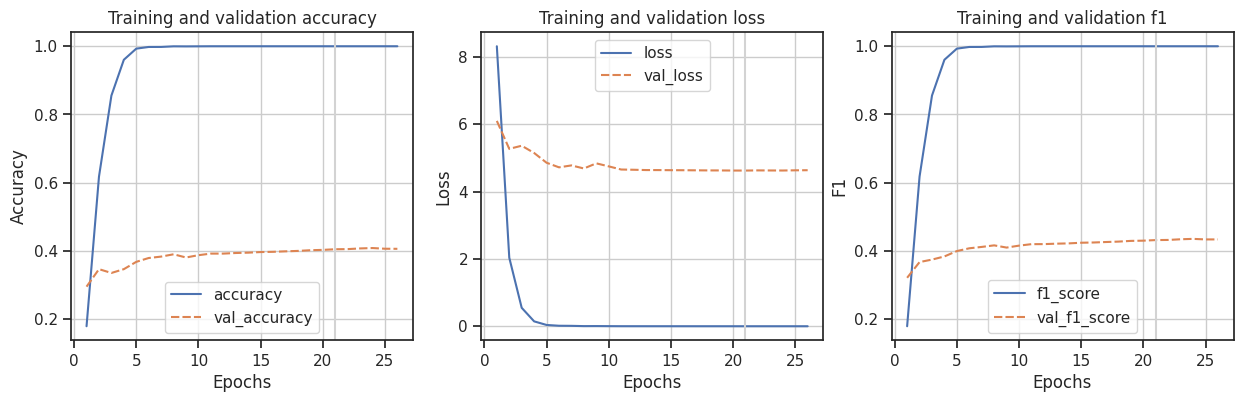

In [ ]:
plot_model_performance(path=os.path.join(MODEL_FOLDER, 'VGG16_dense_audioaug'), axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + "/VGG16_dense_audioaug.h5"))

166/166 [==============================] - 30s 177ms/step - loss: 4.7807 - accuracy: 0.3939 - f1_score: 0.4265

Test loss: 4.781
Test accuracy: 0.394
Test f1: 0.426

Accuracy on test data: 39.39 %
F1-Score on test data: 42.65 %

              precision    recall  f1-score   support

     abhori1       0.50      0.40      0.44        50
     afecuc1       0.39      0.50      0.44        28
     afghor1       0.23      0.40      0.29        20
     afmdov1       0.12      0.40      0.19        15
     afpfly1       0.06      0.10      0.07        31
     afpwag1       0.31      0.54      0.39        24
     afrgos1       0.32      0.50      0.39        24
     afrthr1       0.33      0.57      0.42        30
     amesun2       0.04      0.15      0.07        13
      barswa       0.57      0.36      0.44       166
     bawhor2       0.19      0.47      0.27        15
     bcbeat1       0.17      0.59      0.26        17
     beasun2       0.14      0.42      0.20        12
     bkctch1  

#### Balanced spectrograms augmented (specaug) minority class

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model_dense = keras.Model(inputs, outputs)
model_dense = compile_model(model_dense, "adam")

In [ ]:
history = run_model(model_dense, 'VGG16_dense_specaug', train_set, validation_set, MODEL_FOLDER)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 4.7844 - accuracy: 0.0177 - f1_score: 0.0146
Epoch 1: val_loss improved from inf to 4.63296, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_specaug.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 982s 3s/step - loss: 4.7844 - accuracy: 0.0177 - f1_score: 0.0146 - val_loss: 4.6330 - val_accuracy: 0.0083 - val_f1_score: 0.0030 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 4.5491 - accuracy: 0.0398 - f1_score: 0.0364
Epoch 2: val_loss improved from 4.63296 to 4.38889, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_specaug.h5
313/313 [==============================] - 103s 327ms/step - loss: 4.5491 - accuracy: 0.0398 - f1_score: 0.0364 - val_loss: 4.3889 - val_accuracy: 0.0284 - val_f1_score: 0.0276 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 4.4123 - accuracy: 0.0519 - f1_score: 0.0480
Epoch 3: val_loss improved from 4.38889 to 4.28239, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_specaug.h5
313/313 [==============================] - 102s 322ms/step - loss: 4.4123 - accuracy: 0.0519 - 

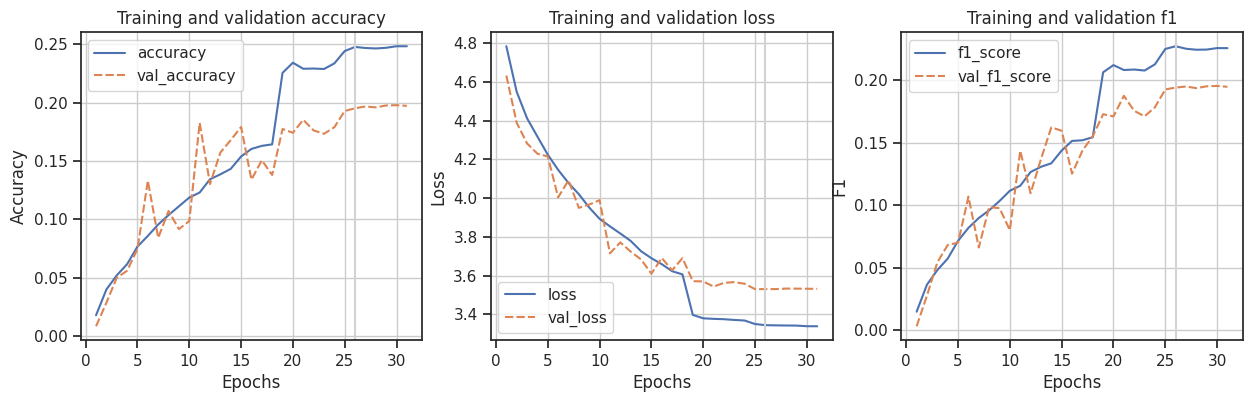

In [ ]:
plot_model_performance(path=os.path.join(MODEL_FOLDER, 'VGG16_dense_specaug'), axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + "/VGG16_dense_specaug.h5"))

166/166 [==============================] - 31s 180ms/step - loss: 3.5341 - accuracy: 0.2024 - f1_score: 0.2073

Test loss: 3.534
Test accuracy: 0.202
Test f1: 0.207

Accuracy on test data: 20.24 %
F1-Score on test data: 20.73 %

              precision    recall  f1-score   support

     abhori1       0.21      0.42      0.28        50
     afecuc1       0.15      0.18      0.16        28
     afghor1       0.16      0.40      0.23        20
     afmdov1       0.00      0.00      0.00        15
     afpfly1       0.00      0.00      0.00        31
     afpwag1       0.13      0.12      0.13        24
     afrgos1       0.06      0.17      0.09        24
     afrthr1       0.22      0.60      0.32        30
     amesun2       0.00      0.00      0.00        13
      barswa       0.23      0.08      0.12       166
     bawhor2       0.04      0.33      0.08        15
     bcbeat1       0.00      0.00      0.00        17
     beasun2       0.18      0.25      0.21        12
     bkctch1  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Balanced spectrograms augmented minority class


In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model_dense = keras.Model(inputs, outputs)
model_dense = compile_model(model_dense, "adam")
model_dense.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0     

In [ ]:
history = run_model(model_dense, 'VGG16_dense_aug', train_set, validation_set, MODEL_FOLDER)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 4.8049 - accuracy: 0.0175 - f1_score: 0.0149
Epoch 1: val_loss improved from inf to 4.37290, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_aug.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 929s 3s/step - loss: 4.8049 - accuracy: 0.0175 - f1_score: 0.0149 - val_loss: 4.3729 - val_accuracy: 0.0747 - val_f1_score: 0.0315 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 4.5575 - accuracy: 0.0352 - f1_score: 0.0315
Epoch 2: val_loss did not improve from 4.37290
313/313 [==============================] - 75s 238ms/step - loss: 4.5575 - accuracy: 0.0352 - f1_score: 0.0315 - val_loss: 4.3928 - val_accuracy: 0.0281 - val_f1_score: 0.0138 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 4.4370 - accuracy: 0.0534 - f1_score: 0.0480
Epoch 3: val_loss improved from 4.37290 to 4.31773, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_aug.h5
313/313 [==============================] - 76s 240ms/step - loss: 4.4370 - accuracy: 0.0534 - f1_score: 0.0480 - val_loss: 4.3177 - val_accuracy: 0.0571 - val_f1_score: 0.0367 - lr: 1.0000e-04
Epoch

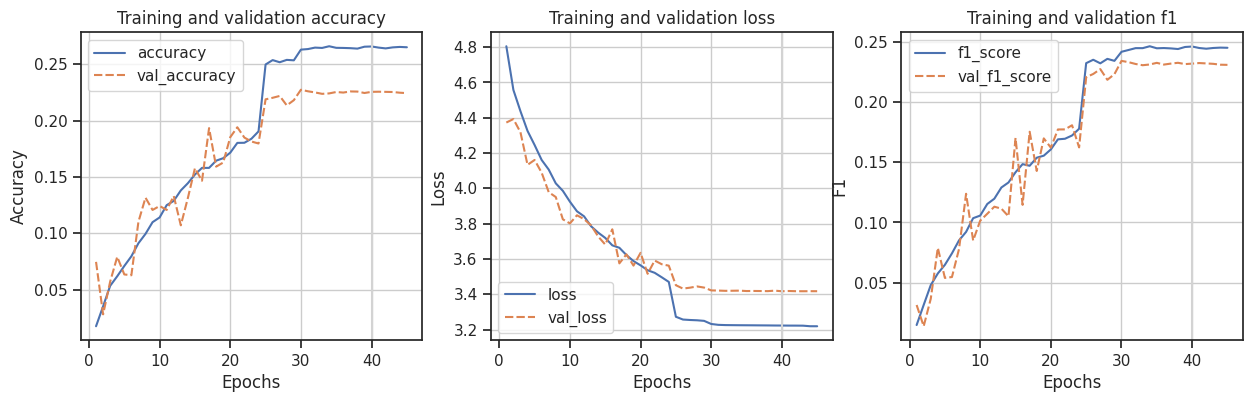

In [ ]:
plot_model_performance(path=os.path.join(MODEL_FOLDER, 'VGG16_dense_aug'), axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + "/VGG16_dense_aug.h5"))

166/166 [==============================] - 22s 131ms/step - loss: 3.4275 - accuracy: 0.2286 - f1_score: 0.2381

Test loss: 3.428
Test accuracy: 0.229
Test f1: 0.238

Accuracy on test data: 22.86 %
F1-Score on test data: 23.81 %

              precision    recall  f1-score   support

     abhori1       0.24      0.46      0.31        50
     afecuc1       0.15      0.11      0.12        28
     afghor1       0.12      0.35      0.18        20
     afmdov1       0.06      0.13      0.09        15
     afpfly1       0.00      0.00      0.00        31
     afpwag1       0.11      0.17      0.14        24
     afrgos1       0.11      0.21      0.14        24
     afrthr1       0.27      0.60      0.37        30
     amesun2       0.00      0.00      0.00        13
      barswa       0.22      0.07      0.11       166
     bawhor2       0.04      0.33      0.07        15
     bcbeat1       0.05      0.06      0.05        17
     beasun2       0.10      0.25      0.14        12
     bkctch1  

#### Unbalanced dataset

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model_dense = keras.Model(inputs, outputs)
model_dense = compile_model(model_dense, "adam")

In [ ]:
history = run_model(model_dense, 'VGG16_dense_noaug', train_set, validation_set, MODEL_FOLDER, weights)


Epoch 1/50
312/312 [==============================] - ETA: 0s - loss: 4.8065 - accuracy: 0.0177 - f1_score: 0.0146
Epoch 1: val_loss improved from inf to 4.52024, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_noaug.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


312/312 [==============================] - 1059s 3s/step - loss: 4.8065 - accuracy: 0.0177 - f1_score: 0.0146 - val_loss: 4.5202 - val_accuracy: 0.0299 - val_f1_score: 0.0065 - lr: 1.0000e-04
Epoch 2/50
312/312 [==============================] - ETA: 0s - loss: 4.5568 - accuracy: 0.0337 - f1_score: 0.0317
Epoch 2: val_loss improved from 4.52024 to 4.29746, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_noaug.h5
312/312 [==============================] - 74s 236ms/step - loss: 4.5568 - accuracy: 0.0337 - f1_score: 0.0317 - val_loss: 4.2975 - val_accuracy: 0.0302 - val_f1_score: 0.0133 - lr: 1.0000e-04
Epoch 3/50
311/312 [============================>.] - ETA: 0s - loss: 4.4361 - accuracy: 0.0487 - f1_score: 0.0453
Epoch 3: val_loss improved from 4.29746 to 4.28811, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_noaug.h5
312/312 [==============================] - 74s 235ms/step - loss: 4.4363 - accuracy: 0.0487 - f1_sc

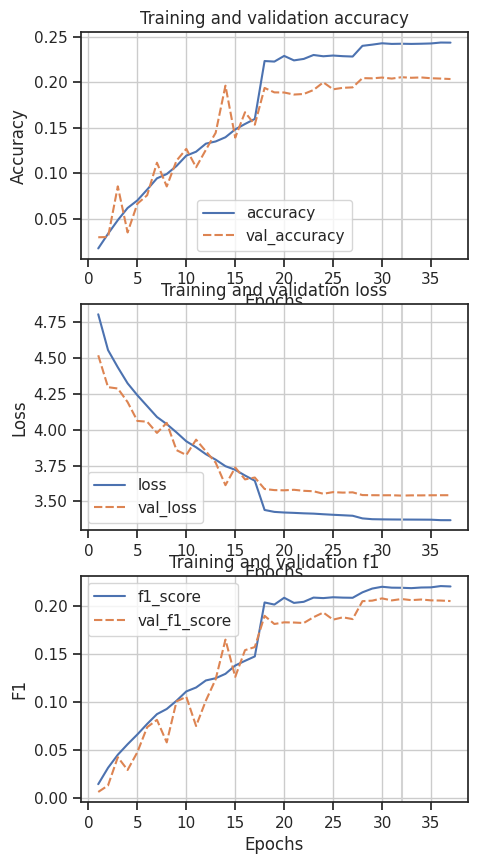

In [ ]:
plot_model_performance(history)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + "/VGG16_dense_noaug.h5"))


166/166 [==============================] - 21s 126ms/step - loss: 3.5489 - accuracy: 0.2020 - f1_score: 0.2069

Test loss: 3.549
Test accuracy: 0.202
Test f1: 0.207

Accuracy on test data: 20.20 %
F1-Score on test data: 20.69 %

              precision    recall  f1-score   support

     abhori1       0.20      0.42      0.27        50
     afecuc1       0.17      0.11      0.13        28
     afghor1       0.10      0.35      0.15        20
     afmdov1       0.07      0.13      0.10        15
     afpfly1       0.00      0.00      0.00        31
     afpwag1       0.07      0.08      0.08        24
     afrgos1       0.08      0.17      0.11        24
     afrthr1       0.24      0.60      0.34        30
     amesun2       0.00      0.00      0.00        13
      barswa       0.22      0.05      0.08       166
     bawhor2       0.04      0.33      0.07        15
     bcbeat1       0.00      0.00      0.00        17
     beasun2       0.12      0.25      0.16        12
     bkctch1  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### All training set augmentation

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = spec_augment(x)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model_dense = keras.Model(inputs, outputs)
model_dense = compile_model(model_dense, "adam")

In [ ]:
history = run_model(model_dense, 'VGG16_dense_allaug', train_set, validation_set, MODEL_FOLDER, weights)


Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/308           ETA: ?s - 

Epoch 1/50
308/308 [==============================] - ETA: 0s - loss: 8.1777 - accuracy: 0.1777 - f1_score: 0.1769
Epoch 1: val_loss improved from inf to 6.15060, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_allaug.h5
308/308 [==============================] - 3641s 12s/step - loss: 8.1777 - accuracy: 0.1777 - f1_score: 0.1769 - val_loss: 6.1506 - val_accuracy: 0.2699 - val_f1_score: 0.2926 - lr: 1.0000e-04
Epoch 2/50


0/308           ETA: ?s - 

Epoch 2/50
308/308 [==============================] - ETA: 0s - loss: 1.9478 - accuracy: 0.6279 - f1_score: 0.6278
Epoch 2: val_loss improved from 6.15060 to 5.56497, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_allaug.h5
308/308 [==============================] - 114s 366ms/step - loss: 1.9478 - accuracy: 0.6279 - f1_score: 0.6278 - val_loss: 5.5650 - val_accuracy: 0.3220 - val_f1_score: 0.3459 - lr: 1.0000e-04
Epoch 3/50


0/308           ETA: ?s - 

Epoch 3/50
308/308 [==============================] - ETA: 0s - loss: 0.5076 - accuracy: 0.8621 - f1_score: 0.8620
Epoch 3: val_loss improved from 5.56497 to 5.36116, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_allaug.h5
308/308 [==============================] - 107s 342ms/step - loss: 0.5076 - accuracy: 0.8621 - f1_score: 0.8620 - val_loss: 5.3612 - val_accuracy: 0.3333 - val_f1_score: 0.3516 - lr: 1.0000e-04
Epoch 4/50


0/308           ETA: ?s - 

Epoch 4/50
308/308 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9683 - f1_score: 0.9683
Epoch 4: val_loss improved from 5.36116 to 5.04411, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_allaug.h5
308/308 [==============================] - 112s 358ms/step - loss: 0.1217 - accuracy: 0.9683 - f1_score: 0.9683 - val_loss: 5.0441 - val_accuracy: 0.3463 - val_f1_score: 0.3704 - lr: 1.0000e-04
Epoch 5/50


0/308           ETA: ?s - 

Epoch 5/50
308/308 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9937 - f1_score: 0.9937
Epoch 5: val_loss improved from 5.04411 to 4.85235, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_allaug.h5
308/308 [==============================] - 113s 362ms/step - loss: 0.0332 - accuracy: 0.9937 - f1_score: 0.9937 - val_loss: 4.8524 - val_accuracy: 0.3613 - val_f1_score: 0.3868 - lr: 1.0000e-04
Epoch 6/50


0/308           ETA: ?s - 

Epoch 6/50
308/308 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 6: val_loss improved from 4.85235 to 4.65735, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_allaug.h5
308/308 [==============================] - 148s 479ms/step - loss: 0.0080 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 4.6573 - val_accuracy: 0.3708 - val_f1_score: 0.3909 - lr: 1.0000e-04
Epoch 7/50


0/308           ETA: ?s - 

Epoch 7/50
308/308 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 7: val_loss improved from 4.65735 to 4.59640, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_allaug.h5
308/308 [==============================] - 107s 345ms/step - loss: 0.0038 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 4.5964 - val_accuracy: 0.3810 - val_f1_score: 0.3999 - lr: 1.0000e-04
Epoch 8/50


0/308           ETA: ?s - 

Epoch 8/50
308/308 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 8: val_loss improved from 4.59640 to 4.59314, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_allaug.h5
308/308 [==============================] - 117s 377ms/step - loss: 0.0027 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 4.5931 - val_accuracy: 0.3811 - val_f1_score: 0.4000 - lr: 1.0000e-04
Epoch 9/50


0/308           ETA: ?s - 

Epoch 9/50
308/308 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 9: val_loss improved from 4.59314 to 4.58002, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_allaug.h5
308/308 [==============================] - 114s 364ms/step - loss: 0.0022 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 4.5800 - val_accuracy: 0.3834 - val_f1_score: 0.4022 - lr: 1.0000e-04
Epoch 10/50


0/308           ETA: ?s - 

Epoch 10/50
308/308 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 10: val_loss did not improve from 4.58002
308/308 [==============================] - 148s 476ms/step - loss: 0.0019 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 4.5850 - val_accuracy: 0.3842 - val_f1_score: 0.4032 - lr: 1.0000e-04
Epoch 11/50


0/308           ETA: ?s - 

Epoch 11/50
308/308 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 11: val_loss did not improve from 4.58002
308/308 [==============================] - 116s 370ms/step - loss: 0.0016 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 4.5807 - val_accuracy: 0.3845 - val_f1_score: 0.4037 - lr: 1.0000e-04
Epoch 12/50


0/308           ETA: ?s - 

Epoch 12/50
308/308 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 12: val_loss did not improve from 4.58002
308/308 [==============================] - 110s 352ms/step - loss: 0.0014 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 4.5804 - val_accuracy: 0.3853 - val_f1_score: 0.4042 - lr: 1.0000e-04
Epoch 13/50


0/308           ETA: ?s - 

Epoch 13/50
308/308 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 13: val_loss did not improve from 4.58002
308/308 [==============================] - 108s 348ms/step - loss: 0.0013 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 4.5903 - val_accuracy: 0.3835 - val_f1_score: 0.4032 - lr: 1.0000e-05
Epoch 14/50


0/308           ETA: ?s - 

Epoch 14/50
308/308 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 14: val_loss did not improve from 4.58002
308/308 [==============================] - 111s 356ms/step - loss: 0.0012 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 4.5962 - val_accuracy: 0.3842 - val_f1_score: 0.4041 - lr: 1.0000e-05
Epoch 14: early stopping


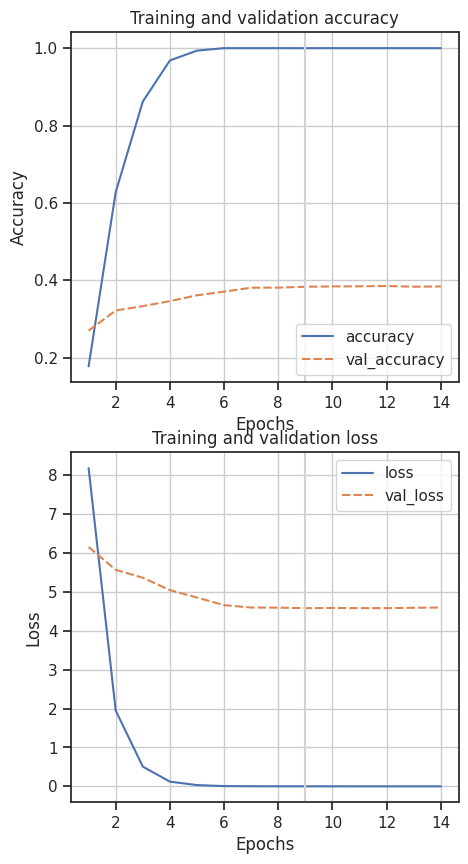

In [ ]:
plot_model_performance(history)


In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + "/VGG16_dense_allaug.h5"))


147/147 [==============================] - 29s 197ms/step - loss: 4.7973 - accuracy: 0.3608 - f1_score: 0.3822

Test loss: 4.797
Test accuracy: 0.361

Accuracy on test data: 36.08 %
F1-Score on test data: 38.22 %

              precision    recall  f1-score   support

     abhori1       0.45      0.28      0.35        50
     afecuc1       0.37      0.39      0.38        28
     afghor1       0.20      0.45      0.27        20
     afmdov1       0.18      0.47      0.26        15
     afpfly1       0.11      0.10      0.10        31
     afpwag1       0.22      0.46      0.30        24
     afrgos1       0.31      0.46      0.37        24
     afrthr1       0.43      0.67      0.53        30
     amesun2       0.08      0.15      0.11        13
      barswa       0.47      0.23      0.31       166
     bawhor2       0.19      0.60      0.29        15
     bcbeat1       0.12      0.41      0.19        17
     bkctch1       0.10      0.12      0.11        32
     blacra1       0.19      

## Flatten + Dense + Dropout

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))

# x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model_dropout = keras.Model(inputs, outputs)
model_dropout = compile_model(model_dropout, "adam")

In [ ]:
model_dropout.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_4 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               6422

In [ ]:
#save_path

history = run_model(model_dropout, 'VGG16_dense_dropout', train_set, validation_set, MODEL_FOLDER)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 13.9100 - accuracy: 0.0909 - f1_score: 0.0895
Epoch 1: val_loss improved from inf to 6.51867, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_dropout.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 82s 258ms/step - loss: 13.9100 - accuracy: 0.0909 - f1_score: 0.0895 - val_loss: 6.5187 - val_accuracy: 0.2694 - val_f1_score: 0.2930 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 6.8684 - accuracy: 0.3126 - f1_score: 0.3096
Epoch 2: val_loss improved from 6.51867 to 5.69036, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_dropout.h5
313/313 [==============================] - 72s 228ms/step - loss: 6.8684 - accuracy: 0.3126 - f1_score: 0.3096 - val_loss: 5.6904 - val_accuracy: 0.3323 - val_f1_score: 0.3648 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 4.0885 - accuracy: 0.4717 - f1_score: 0.4693
Epoch 3: val_loss improved from 5.69036 to 5.32067, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_dense_dropout.h5
313/313 [==============================] - 72s 227ms/step - loss: 4.0885 - accuracy: 0.4717 -

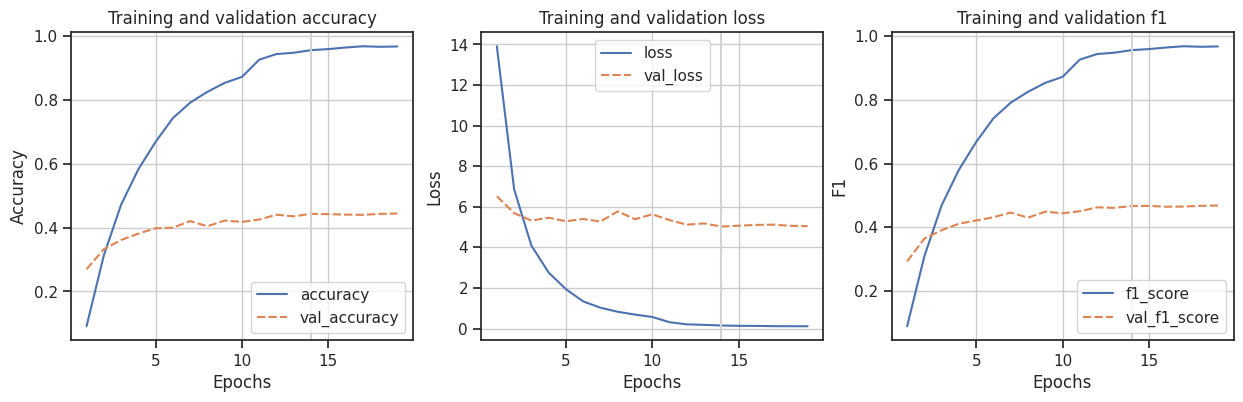

In [ ]:
plot_model_performance(history, axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + '/VGG16_dense_dropout.h5'))

166/166 [==============================] - 22s 128ms/step - loss: 5.2394 - accuracy: 0.4352 - f1_score: 0.4620

Test loss: 5.239
Test accuracy: 0.435
Test f1: 0.462

Accuracy on test data: 43.52 %
F1-Score on test data: 46.20 %

              precision    recall  f1-score   support

     abhori1       0.44      0.38      0.41        50
     afecuc1       0.41      0.46      0.43        28
     afghor1       0.24      0.50      0.32        20
     afmdov1       0.20      0.67      0.31        15
     afpfly1       0.11      0.19      0.14        31
     afpwag1       0.30      0.54      0.38        24
     afrgos1       0.31      0.58      0.41        24
     afrthr1       0.40      0.70      0.51        30
     amesun2       0.08      0.23      0.12        13
      barswa       0.63      0.32      0.42       166
     bawhor2       0.24      0.53      0.33        15
     bcbeat1       0.11      0.53      0.19        17
     beasun2       0.17      0.42      0.24        12
     bkctch1  

## GlobalAvgPooling + Dense (SpecAugment)


1.   GlobalAveragePooling2D
2.   Dense (256)



In [ ]:
inputs = keras.Input(shape=(224,224,3))
# inputs = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(100, activation="softmax")(x)
model_avgpooling = keras.Model(inputs, outputs)

print(model_avgpooling.summary())
model_avgpooling = compile_model(model_avgpooling, "adam")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 4.9596 - accuracy: 0.0203 - f1_score: 0.0180
Epoch 1: val_loss improved from inf to 4.51762, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/VGG16_avgpooling_dense_specaug.h5
313/313 [==============================] - 1204s 4s/step - loss: 4.9596 - accuracy: 0.0203 - f1_score: 0.0180 - val_loss: 4.5176 - val_accuracy: 0.0398 - val_f1_score: 0.0475 - lr: 1.0000e-04


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 4.2826 - accuracy: 0.0725 - f1_score: 0.0647
Epoch 2: val_loss improved from 4.51762 to 4.16456, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/VGG16_avgpooling_dense_specaug.h5
313/313 [==============================] - 102s 324ms/step - loss: 4.2826 - accuracy: 0.0725 - f1_score: 0.0647 - val_loss: 4.1646 - val_accuracy: 0.0914 - val_f1_score: 0.1040 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 3.9232 - accuracy: 0.1339 - f1_score: 0.1218
Epoch 3: val_loss improved from 4.16456 to 3.90078, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/VGG16_avgpooling_dense_specaug.h5
313/313 [==============================] - 140s 444ms/step - loss: 3.9232 - accuracy: 0.1339 - f1_score: 0.1218 - val_loss: 3.9008 - val_accuracy: 0.1462 - val_f1_score: 0.1602 - lr: 1.0000e-04
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 3.6410

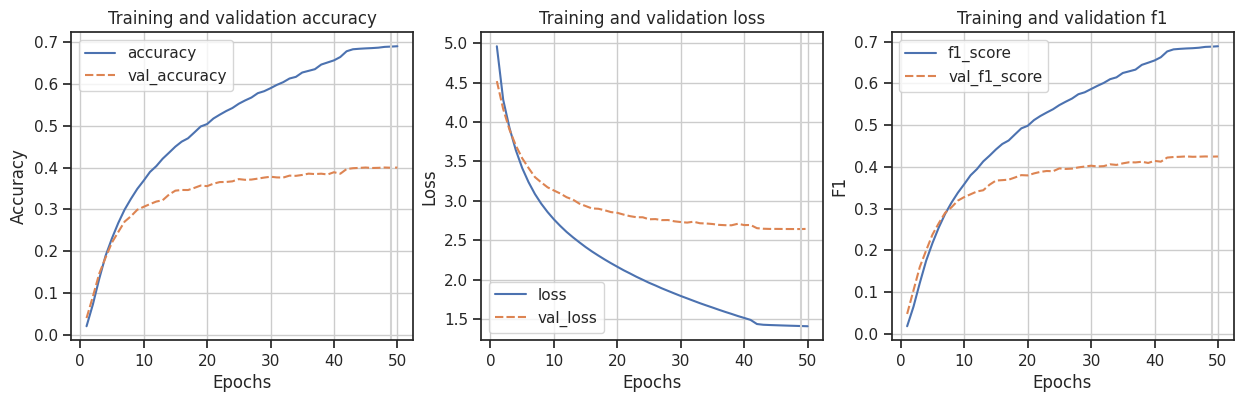

In [ ]:
# history_avgpooling = model.fit(
#     train_set,
#     epochs=50, # 50 epochs take approximately 15 minutes
#     validation_data=validation_set,
#     callbacks = callbacks_list,
#     class_weight = weights
# )

history = run_model(model_avgpooling, 'VGG16_avgpooling_dense_specaug', train_set, validation_set, MODEL_FOLDER)
plot_model_performance(history, axis=0)

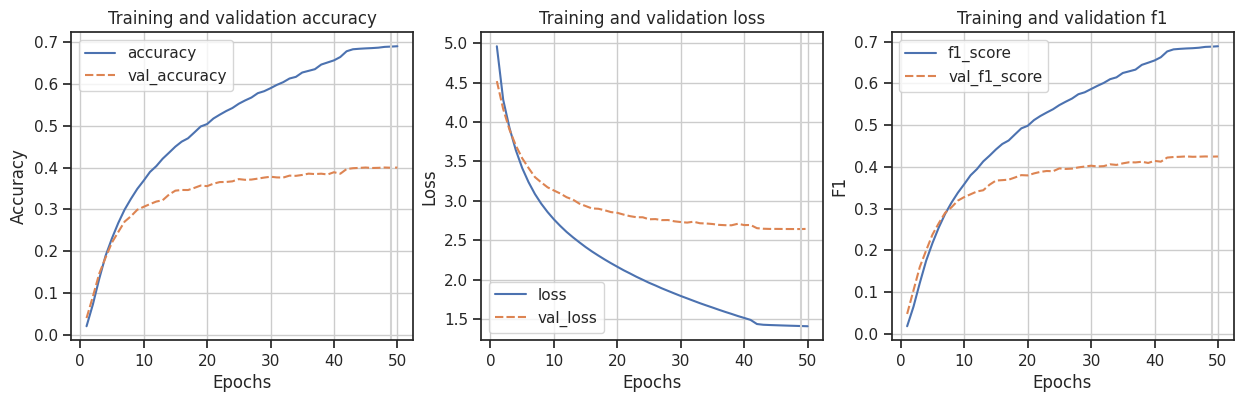

In [ ]:
plot_model_performance(path=os.path.join(MODEL_FOLDER, 'VGG16_avgpooling_dense_specaug'), axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + 'VGG16_avgpooling_dense_specaug.h5'))

166/166 [==============================] - 29s 170ms/step - loss: 2.6786 - accuracy: 0.3884 - f1_score: 0.4162

Test loss: 2.679
Test accuracy: 0.388
Test f1: 0.416

Accuracy on test data: 38.84 %
F1-Score on test data: 41.62 %

              precision    recall  f1-score   support

     abhori1       0.30      0.40      0.34        50
     afecuc1       0.54      0.54      0.54        28
     afghor1       0.27      0.45      0.34        20
     afmdov1       0.16      0.53      0.25        15
     afpfly1       0.15      0.13      0.14        31
     afpwag1       0.23      0.50      0.32        24
     afrgos1       0.42      0.58      0.49        24
     afrthr1       0.30      0.47      0.36        30
     amesun2       0.03      0.08      0.04        13
      barswa       0.46      0.27      0.34       166
     bawhor2       0.17      0.60      0.26        15
     bcbeat1       0.13      0.53      0.21        17
     beasun2       0.18      0.58      0.28        12
     bkctch1  

## GlobalAvgPooling + Dense (spectrograms augmentation)


1.   GlobalAveragePooling2D
2.   Dense (256)



In [ ]:
inputs = keras.Input(shape=(224,224,3))
# inputs = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(100, activation="softmax")(x)
model_avgpooling = keras.Model(inputs, outputs)

print(model_avgpooling.summary())
model_avgpooling = compile_model(model_avgpooling, "adam")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                           

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 5.0540 - accuracy: 0.0185 - f1_score: 0.0163
Epoch 1: val_loss improved from inf to 4.54569, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dense_spec.h5
313/313 [==============================] - 512s 2s/step - loss: 5.0540 - accuracy: 0.0185 - f1_score: 0.0163 - val_loss: 4.5457 - val_accuracy: 0.0346 - val_f1_score: 0.0385 - lr: 1.0000e-04
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 4.3128 - accuracy: 0.0690 - f1_score: 0.0609
Epoch 2: val_loss improved from 4.54569 to 4.18157, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dense_spec.h5
313/313 [==============================] - 77s 245ms/step - loss: 4.3128 - accuracy: 0.0690 - f1_score: 0.0609 - val_loss: 4.1816 - val_accuracy: 0.0854 - val_f1_score: 0.0924 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 3.9422 - accuracy: 0.1243 - f1_score: 0.1126
Epoch 3: val_loss improved from 4.18157 to 3.91440, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dense_spec.h5
313/313 [==============================] - 78s 248ms/step - loss: 3.9422 - accuracy: 0.1243 - f1_score: 0.1126 - val_loss: 3.9144 - val_accuracy: 0.1315 - val_f1_score: 0.1446 - lr: 1.0000e-04
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 3.6505 - accuracy: 

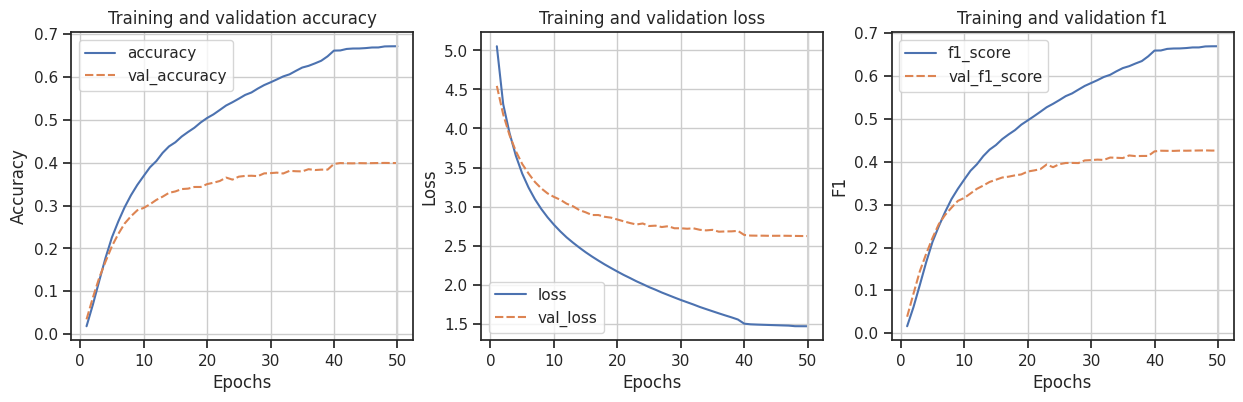

In [ ]:
# history_avgpooling = model.fit(
#     train_set,
#     epochs=50, # 50 epochs take approximately 15 minutes
#     validation_data=validation_set,
#     callbacks = callbacks_list,
#     class_weight = weights
# )

history = run_model(model_avgpooling, 'VGG16_avgpooling_dense_spec', train_set, validation_set, MODEL_FOLDER)
plot_model_performance(history, axis=0)

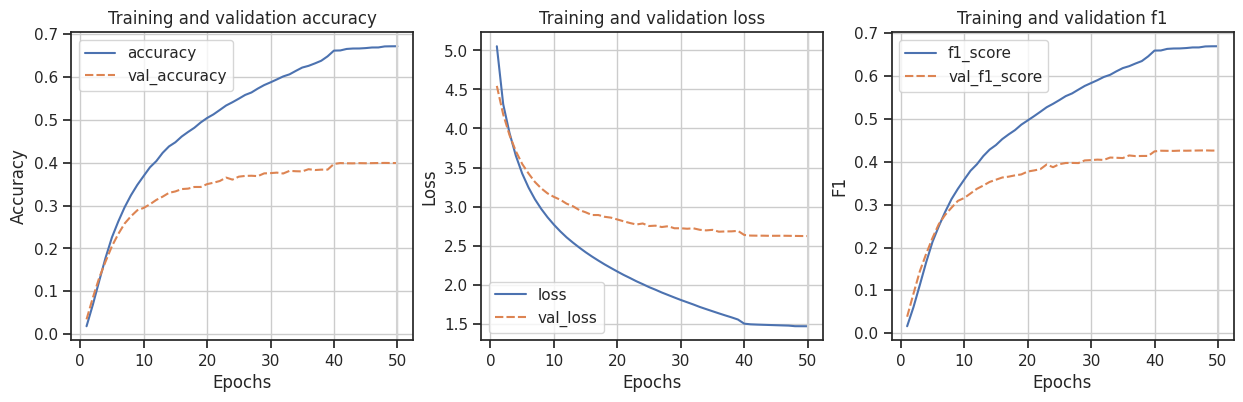

In [ ]:
plot_model_performance(path=os.path.join(MODEL_FOLDER, 'VGG16_avgpooling_dense_spec'), axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + 'VGG16_avgpooling_dense_spec.h5'))

166/166 [==============================] - 24s 141ms/step - loss: 2.6669 - accuracy: 0.3901 - f1_score: 0.4179

Test loss: 2.667
Test accuracy: 0.390
Test f1: 0.418

Accuracy on test data: 39.01 %
F1-Score on test data: 41.79 %

              precision    recall  f1-score   support

     abhori1       0.35      0.38      0.36        50
     afecuc1       0.38      0.54      0.44        28
     afghor1       0.20      0.35      0.25        20
     afmdov1       0.14      0.40      0.21        15
     afpfly1       0.23      0.19      0.21        31
     afpwag1       0.21      0.42      0.28        24
     afrgos1       0.39      0.75      0.51        24
     afrthr1       0.37      0.57      0.45        30
     amesun2       0.03      0.08      0.05        13
      barswa       0.53      0.23      0.32       166
     bawhor2       0.25      0.67      0.36        15
     bcbeat1       0.09      0.41      0.15        17
     beasun2       0.12      0.42      0.19        12
     bkctch1  

## GlobalAvgPooling + Dense


1.   GlobalAveragePooling2D
2.   Dense (256)



In [ ]:
inputs = keras.Input(shape=(224,224,3))
# inputs = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(100, activation="softmax")(x)
model_avgpooling = keras.Model(inputs, outputs)

print(model_avgpooling.summary())
model_avgpooling = compile_model(model_avgpooling, "adam")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 4.9415 - accuracy: 0.0253 - f1_score: 0.0241
Epoch 1: val_loss improved from inf to 4.52048, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dense.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 80s 251ms/step - loss: 4.9415 - accuracy: 0.0253 - f1_score: 0.0241 - val_loss: 4.5205 - val_accuracy: 0.0333 - val_f1_score: 0.0344 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 4.2487 - accuracy: 0.0816 - f1_score: 0.0721
Epoch 2: val_loss improved from 4.52048 to 4.13357, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dense.h5
313/313 [==============================] - 78s 249ms/step - loss: 4.2487 - accuracy: 0.0816 - f1_score: 0.0721 - val_loss: 4.1336 - val_accuracy: 0.0913 - val_f1_score: 0.1000 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 3.8770 - accuracy: 0.1450 - f1_score: 0.1313
Epoch 3: val_loss improved from 4.13357 to 3.84515, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dense.h5
313/313 [==============================] - 78s 247ms/step - loss: 3.8770 - accuracy: 0.1

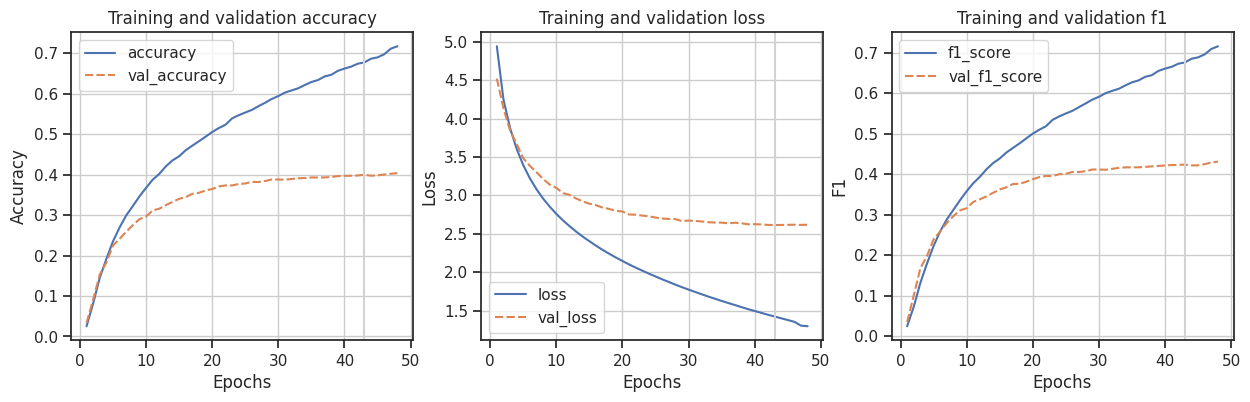

In [ ]:
history = run_model(model_avgpooling, 'VGG16_avgpooling_dense', train_set, validation_set, MODEL_FOLDER)
plot_model_performance(history, axis=0)

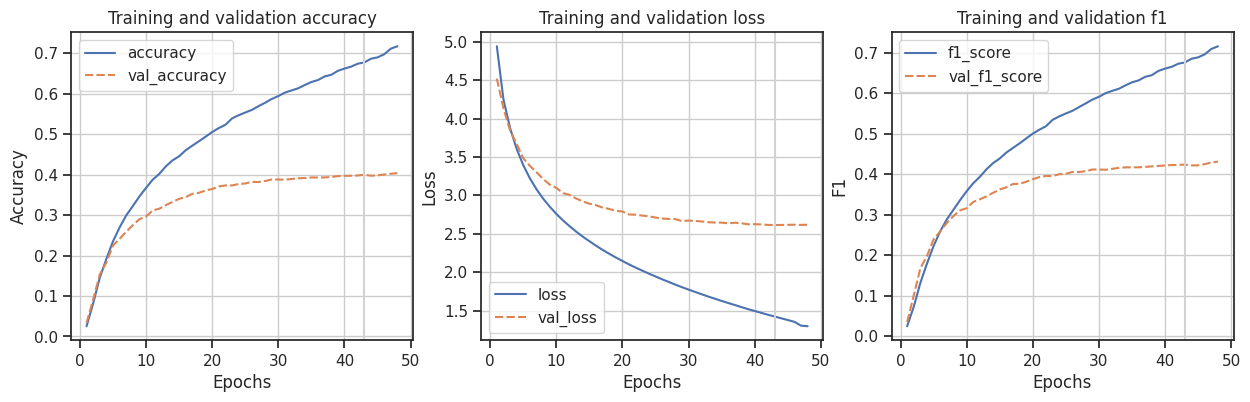

In [ ]:
plot_model_performance(path=os.path.join(MODEL_FOLDER, 'VGG16_avgpooling_dense'), axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + 'VGG16_avgpooling_dense.h5'))

166/166 [==============================] - 24s 141ms/step - loss: 2.6606 - accuracy: 0.3963 - f1_score: 0.4234

Test loss: 2.661
Test accuracy: 0.396
Test f1: 0.423

Accuracy on test data: 39.63 %
F1-Score on test data: 42.34 %

              precision    recall  f1-score   support

     abhori1       0.35      0.40      0.37        50
     afecuc1       0.52      0.46      0.49        28
     afghor1       0.30      0.40      0.34        20
     afmdov1       0.14      0.47      0.22        15
     afpfly1       0.17      0.13      0.15        31
     afpwag1       0.16      0.33      0.22        24
     afrgos1       0.40      0.71      0.51        24
     afrthr1       0.31      0.50      0.38        30
     amesun2       0.04      0.15      0.06        13
      barswa       0.45      0.27      0.34       166
     bawhor2       0.22      0.67      0.33        15
     bcbeat1       0.13      0.53      0.21        17
     beasun2       0.17      0.33      0.23        12
     bkctch1  

## GlobalAveragePooling + BatchNormalization

In [ ]:
inputs = keras.Input(shape=(224,224,3))
# inputs = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layer.BatchNormalization()(x)
outputs = layers.Dense(100, activation="softmax")(x)
model_avgpooling = keras.Model(inputs, outputs)

print(model_avgpooling.summary())
model_avgpooling = compile_model(model_avgpooling, "adam")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 5.3852 - accuracy: 0.0218 - f1_score: 0.0217
Epoch 1: val_loss improved from inf to 4.54893, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling.h5
313/313 [==============================] - 72s 227ms/step - loss: 5.3852 - accuracy: 0.0218 - f1_score: 0.0217 - val_loss: 4.5489 - val_accuracy: 0.0568 - val_f1_score: 0.0670 - lr: 1.0000e-04


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 4.2660 - accuracy: 0.0886 - f1_score: 0.0838
Epoch 2: val_loss improved from 4.54893 to 4.02218, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling.h5
313/313 [==============================] - 82s 259ms/step - loss: 4.2660 - accuracy: 0.0886 - f1_score: 0.0838 - val_loss: 4.0222 - val_accuracy: 0.1233 - val_f1_score: 0.1406 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 3.8020 - accuracy: 0.1491 - f1_score: 0.1413
Epoch 3: val_loss improved from 4.02218 to 3.72668, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling.h5
313/313 [==============================] - 73s 232ms/step - loss: 3.8020 - accuracy: 0.1491 - f1_score: 0.1413 - val_loss: 3.7267 - val_accuracy: 0.1758 - val_f1_score: 0.1959 - lr: 1.0000e-04
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 3.5064 - accuracy: 0.2061 - f1

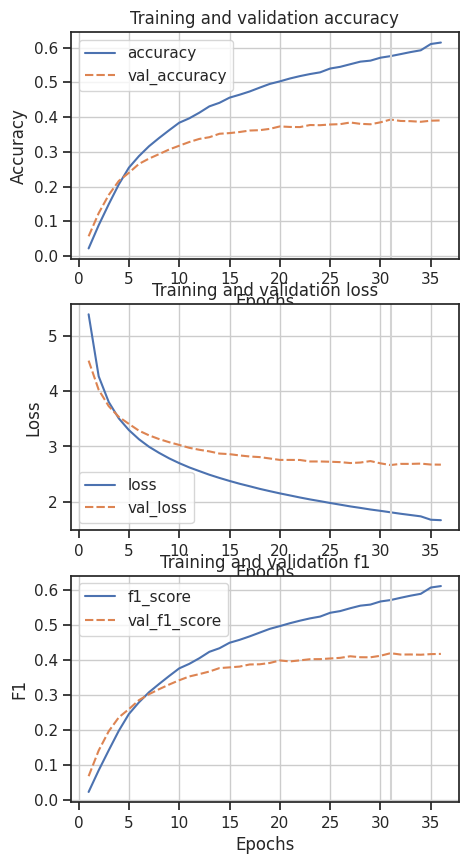

In [ ]:
# history_avgpooling = model.fit(
#     train_set,
#     epochs=50, # 50 epochs take approximately 15 minutes
#     validation_data=validation_set,
#     callbacks = callbacks_list,
#     class_weight = weights
# )

history = run_model(model_avgpooling, 'VGG16_gap_batchnorm', train_set, validation_set, MODEL_FOLDER)
plot_model_performance(history)

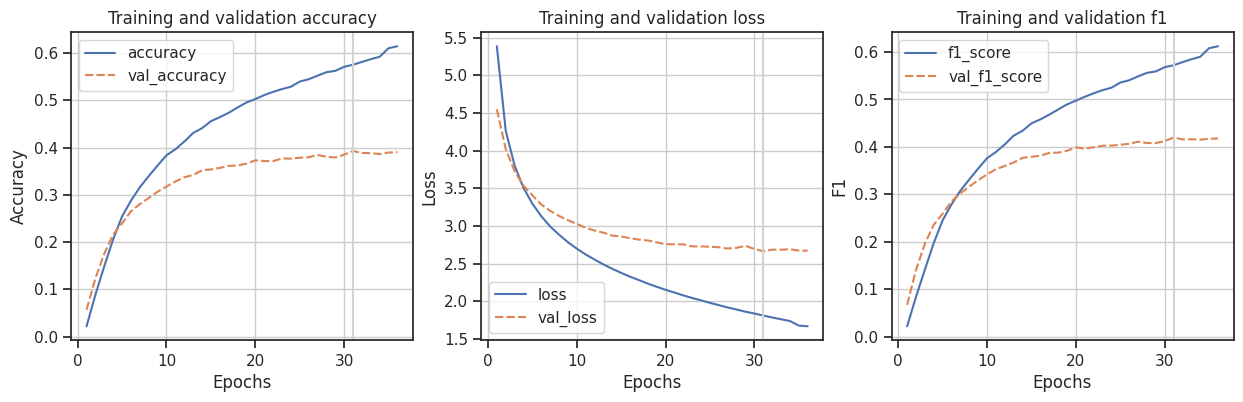

In [ ]:
plot_model_performance(path=os.path.join(MODEL_FOLDER, 'VGG16_gap'), axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + 'VGG16_gap.h5'))

166/166 [==============================] - 22s 131ms/step - loss: 2.7122 - accuracy: 0.3856 - f1_score: 0.4139

Test loss: 2.712
Test accuracy: 0.386
Test f1: 0.414

Accuracy on test data: 38.56 %
F1-Score on test data: 41.39 %

              precision    recall  f1-score   support

     abhori1       0.26      0.42      0.32        50
     afecuc1       0.56      0.54      0.55        28
     afghor1       0.25      0.35      0.29        20
     afmdov1       0.12      0.53      0.20        15
     afpfly1       0.12      0.06      0.09        31
     afpwag1       0.25      0.42      0.31        24
     afrgos1       0.36      0.67      0.46        24
     afrthr1       0.45      0.50      0.48        30
     amesun2       0.04      0.08      0.06        13
      barswa       0.55      0.17      0.26       166
     bawhor2       0.21      0.67      0.32        15
     bcbeat1       0.09      0.41      0.14        17
     bkctch1       0.17      0.19      0.18        32
     blacra1  

In [ ]:
inputs = keras.Input(shape=(224,224,3))
# inputs = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(100, activation="softmax")(x)
model_avgpooling = keras.Model(inputs, outputs)

print(model_avgpooling.summary())
model_avgpooling = compile_model(model_avgpooling, "adam")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 4.9041 - accuracy: 0.0222 - f1_score: 0.0191
Epoch 1: val_loss improved from inf to 4.49028, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dense.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 3330s 11s/step - loss: 4.9041 - accuracy: 0.0222 - f1_score: 0.0191 - val_loss: 4.4903 - val_accuracy: 0.0406 - val_f1_score: 0.0445 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 4.2352 - accuracy: 0.0814 - f1_score: 0.0741
Epoch 2: val_loss improved from 4.49028 to 4.13286, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dense.h5
313/313 [==============================] - 72s 227ms/step - loss: 4.2352 - accuracy: 0.0814 - f1_score: 0.0741 - val_loss: 4.1329 - val_accuracy: 0.1011 - val_f1_score: 0.1108 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 3.8579 - accuracy: 0.1490 - f1_score: 0.1381
Epoch 3: val_loss improved from 4.13286 to 3.82461, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dense.h5
313/313 [==============================] - 71s 224ms/step - loss: 3.8579 - accuracy: 0.1

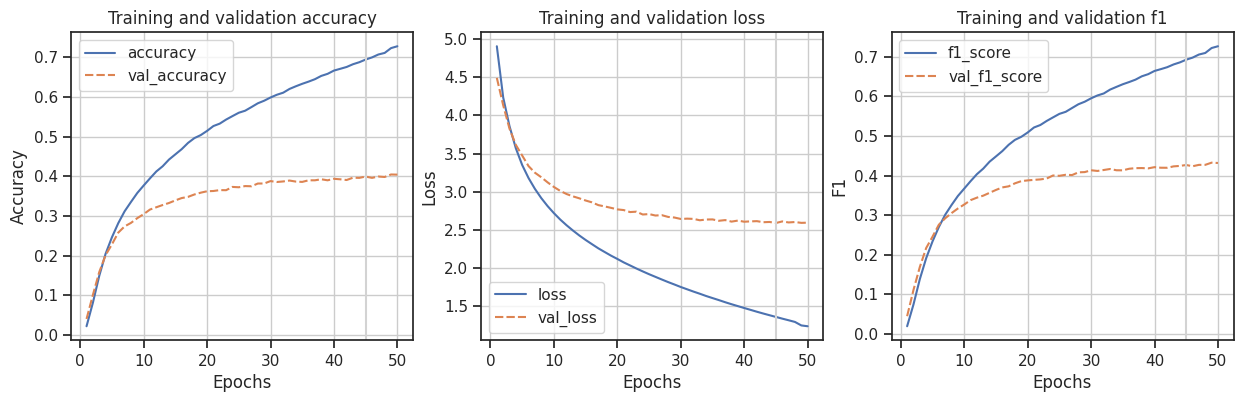

In [ ]:
# history_avgpooling = model.fit(
#     train_set,
#     epochs=50, # 50 epochs take approximately 15 minutes
#     validation_data=validation_set,
#     callbacks = callbacks_list,
#     class_weight = weights
# )

history = run_model(model_avgpooling, 'VGG16_avgpooling_dense_spec, train_set, validation_set, MODEL_FOLDER)
plot_model_performance(history, axis=0)

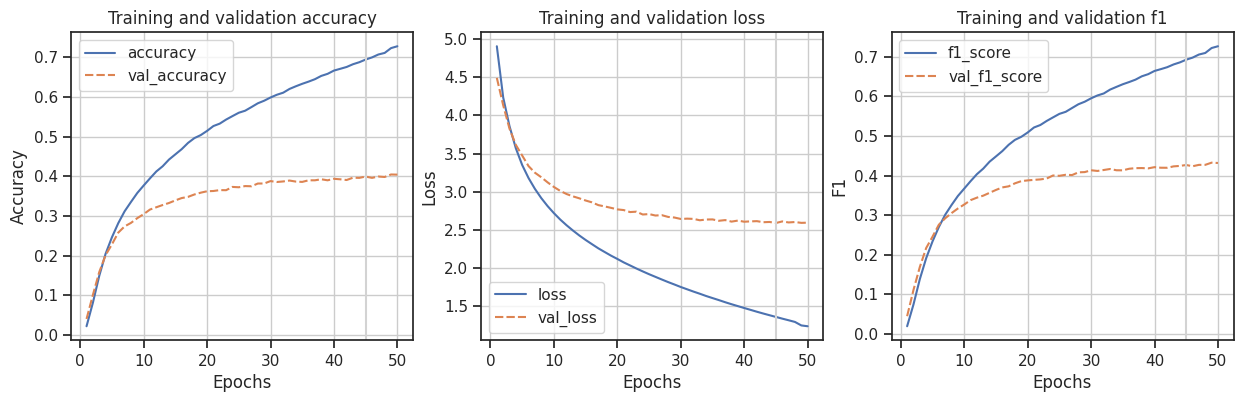

In [ ]:
plot_model_performance(path=os.path.join(MODEL_FOLDER, 'VGG16_avgpooling_dense_spec'), axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + 'VGG16_avgpooling_dense_spec.h5'))

166/166 [==============================] - 21s 124ms/step - loss: 5.6556 - accuracy: 0.1534 - f1_score: 0.1712

Test loss: 5.656
Test accuracy: 0.153
Test f1: 0.171

Accuracy on test data: 15.34 %
F1-Score on test data: 17.12 %

              precision    recall  f1-score   support

     abhori1       0.27      0.42      0.33        50
     afecuc1       0.56      0.54      0.55        28
     afghor1       0.25      0.35      0.29        20
     afmdov1       0.12      0.53      0.20        15
     afpfly1       0.13      0.06      0.09        31
     afpwag1       0.24      0.42      0.31        24
     afrgos1       0.34      0.67      0.45        24
     afrthr1       0.45      0.50      0.48        30
     amesun2       0.04      0.08      0.06        13
      barswa       0.55      0.17      0.26       166
     bawhor2       0.21      0.67      0.32        15
     bcbeat1       0.09      0.41      0.14        17
     beasun2       0.00      0.00      0.00        12
     bkctch1  

## GlobalAvgPooling + Dense + Dropout


1.   GlobalAveragePooling2D
2.   Dense
3.   Dropout

In [ ]:
inputs = keras.Input(shape=(224,224,3))
# inputs = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(100, activation="softmax", name='prediction')(x)
model_avgpooling_dropout = keras.Model(inputs, outputs)
model_avgpooling_dropout = compile_model(model_avgpooling_dropout, "adam")
print(model_avgpooling_dropout.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_6  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_6 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_6  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 5.2241 - accuracy: 0.0168 - f1_score: 0.0161
Epoch 1: val_loss improved from inf to 4.52451, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dropout.h5
313/313 [==============================] - 76s 238ms/step - loss: 5.2241 - accuracy: 0.0168 - f1_score: 0.0161 - val_loss: 4.5245 - val_accuracy: 0.0468 - val_f1_score: 0.0561 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 4.4590 - accuracy: 0.0457 - f1_score: 0.0401
Epoch 2: val_loss improved from 4.52451 to 4.27794, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dropout.h5
313/313 [==============================] - 75s 236ms/step - loss: 4.4590 - accuracy: 0.0457 - f1_score: 0.0401 - val_loss: 4.2779 - val_accuracy: 0.0871 - val_f1_score: 0.0951 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 4.2016 - accuracy:

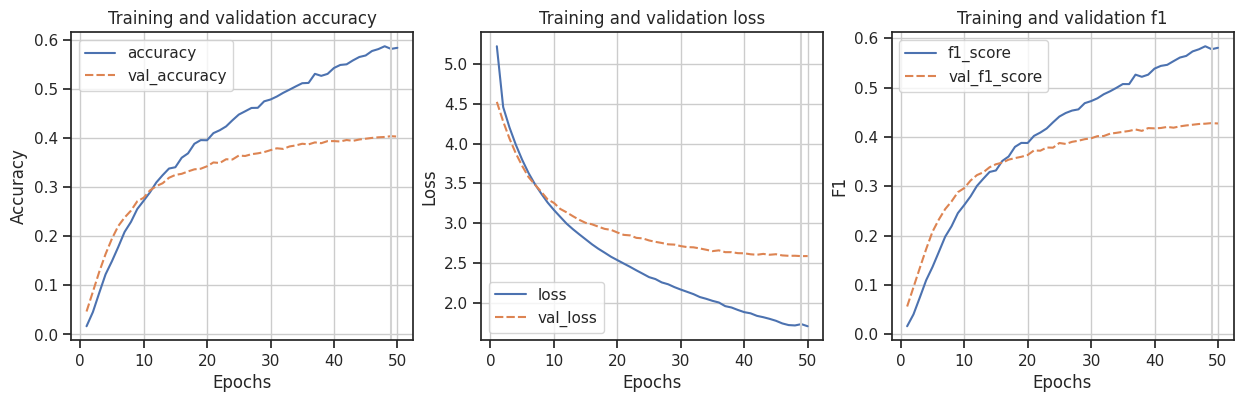

In [ ]:
history = run_model(model_avgpooling_dropout, 'VGG16_avgpooling_dropout', train_set, validation_set, MODEL_FOLDER)
plot_model_performance(history, axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + '/VGG16_avgpooling_dropout.h5'))

166/166 [==============================] - 23s 135ms/step - loss: 2.6361 - accuracy: 0.3939 - f1_score: 0.4201

Test loss: 2.636
Test accuracy: 0.394
Test f1: 0.420

Accuracy on test data: 39.39 %
F1-Score on test data: 42.01 %

              precision    recall  f1-score   support

     abhori1       0.33      0.40      0.36        50
     afecuc1       0.43      0.54      0.48        28
     afghor1       0.22      0.40      0.29        20
     afmdov1       0.17      0.47      0.25        15
     afpfly1       0.20      0.13      0.16        31
     afpwag1       0.22      0.42      0.29        24
     afrgos1       0.32      0.58      0.41        24
     afrthr1       0.41      0.53      0.46        30
     amesun2       0.03      0.08      0.04        13
      barswa       0.44      0.22      0.29       166
     bawhor2       0.17      0.47      0.25        15
     bcbeat1       0.11      0.47      0.18        17
     beasun2       0.15      0.42      0.22        12
     bkctch1  

##GlobalAveragePooling + BatchNormalization + Dense + Dropout

In [ ]:
inputs = keras.Input(shape=(224,224,3))
# inputs = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(100, activation="softmax", name='prediction')(x)
model_avgpooling_dropout_dense = keras.Model(inputs, outputs)
model_avgpooling_dropout_dense = compile_model(model_avgpooling_dropout_dense, "adam")
print(model_avgpooling_dropout_dense.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

In [ ]:
history = run_model(model_avgpooling_dropout_dense, 'VGG16_avgpooling_dropout_batchnorm', train_set, validation_set, MODEL_FOLDER)


Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 4.8882 - accuracy: 0.0158 - f1_score: 0.0142
Epoch 1: val_loss improved from inf to 4.46582, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dropout_batchnorm.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 78s 243ms/step - loss: 4.8882 - accuracy: 0.0158 - f1_score: 0.0142 - val_loss: 4.4658 - val_accuracy: 0.0371 - val_f1_score: 0.0408 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 4.4405 - accuracy: 0.0525 - f1_score: 0.0501
Epoch 2: val_loss improved from 4.46582 to 4.27096, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dropout_batchnorm.h5
313/313 [==============================] - 75s 238ms/step - loss: 4.4405 - accuracy: 0.0525 - f1_score: 0.0501 - val_loss: 4.2710 - val_accuracy: 0.0780 - val_f1_score: 0.0832 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 4.1450 - accuracy: 0.0940 - f1_score: 0.0881
Epoch 3: val_loss improved from 4.27096 to 4.07911, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_avgpooling_dropout_batchnorm.h5
313/313 [==============================] - 76s 239ms/step - loss

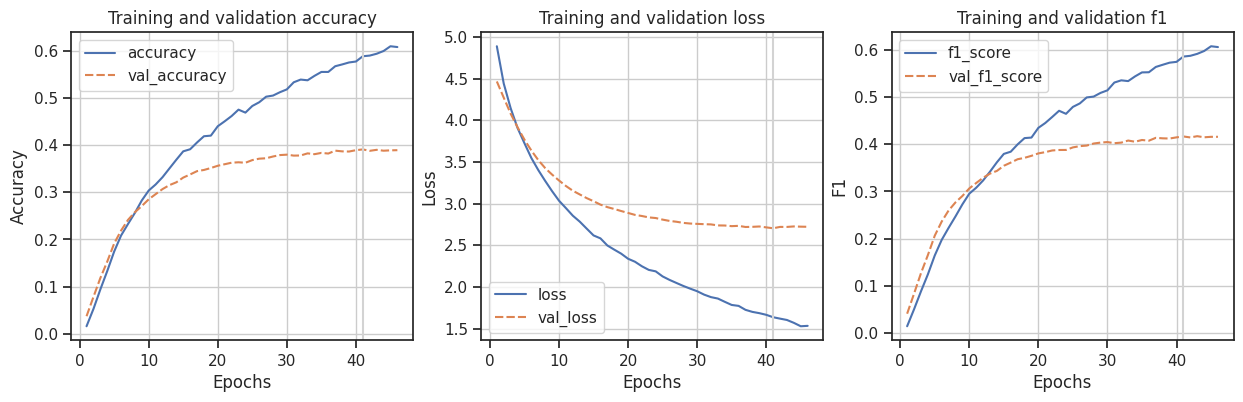

In [ ]:
plot_model_performance(history, axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + '/VGG16_avgpooling_dropout_batchnorm.h5'))

166/166 [==============================] - 23s 138ms/step - loss: 2.7313 - accuracy: 0.3881 - f1_score: 0.4146

Test loss: 2.731
Test accuracy: 0.388
Test f1: 0.415

Accuracy on test data: 38.81 %
F1-Score on test data: 41.46 %

              precision    recall  f1-score   support

     abhori1       0.34      0.42      0.38        50
     afecuc1       0.45      0.64      0.53        28
     afghor1       0.27      0.35      0.30        20
     afmdov1       0.23      0.47      0.31        15
     afpfly1       0.19      0.19      0.19        31
     afpwag1       0.22      0.42      0.29        24
     afrgos1       0.33      0.67      0.44        24
     afrthr1       0.36      0.57      0.44        30
     amesun2       0.02      0.08      0.03        13
      barswa       0.47      0.27      0.34       166
     bawhor2       0.14      0.40      0.20        15
     bcbeat1       0.10      0.35      0.16        17
     beasun2       0.15      0.50      0.23        12
     bkctch1  

##GlobalAveragePooling + BatchNormalization + Dense (256) + Dense (128) + Dropout

In [ ]:
inputs = keras.Input(shape=(224,224,3))
# inputs = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(100, activation="softmax", name='prediction')(x)
model_avgpooling_dropout_dense = keras.Model(inputs, outputs)
model_avgpooling_dropout_dense = compile_model(model_avgpooling_dropout_dense, "adam")
print(model_avgpooling_dropout_dense.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:
history = run_model(model_avgpooling_dropout_dense, 'VGG16_2avgpooling_dropout_batchnorm', train_set, validation_set, MODEL_FOLDER)


Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 4.7457 - accuracy: 0.0122 - f1_score: 0.0102
Epoch 1: val_loss improved from inf to 4.54163, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/VGG16_2avgpooling_dropout_batchnorm.h5
313/313 [==============================] - 1023s 3s/step - loss: 4.7457 - accuracy: 0.0122 - f1_score: 0.0102 - val_loss: 4.5416 - val_accuracy: 0.0254 - val_f1_score: 0.0302 - lr: 1.0000e-04


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 4.5507 - accuracy: 0.0228 - f1_score: 0.0203
Epoch 2: val_loss improved from 4.54163 to 4.46874, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/VGG16_2avgpooling_dropout_batchnorm.h5
313/313 [==============================] - 75s 237ms/step - loss: 4.5507 - accuracy: 0.0228 - f1_score: 0.0203 - val_loss: 4.4687 - val_accuracy: 0.0466 - val_f1_score: 0.0538 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 4.4596 - accuracy: 0.0367 - f1_score: 0.0328
Epoch 3: val_loss improved from 4.46874 to 4.38752, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/VGG16_2avgpooling_dropout_batchnorm.h5
313/313 [==============================] - 74s 235ms/step - loss: 4.4596 - accuracy: 0.0367 - f1_score: 0.0328 - val_loss: 4.3875 - val_accuracy: 0.0698 - val_f1_score: 0.0769 - lr: 1.0000e-04
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss

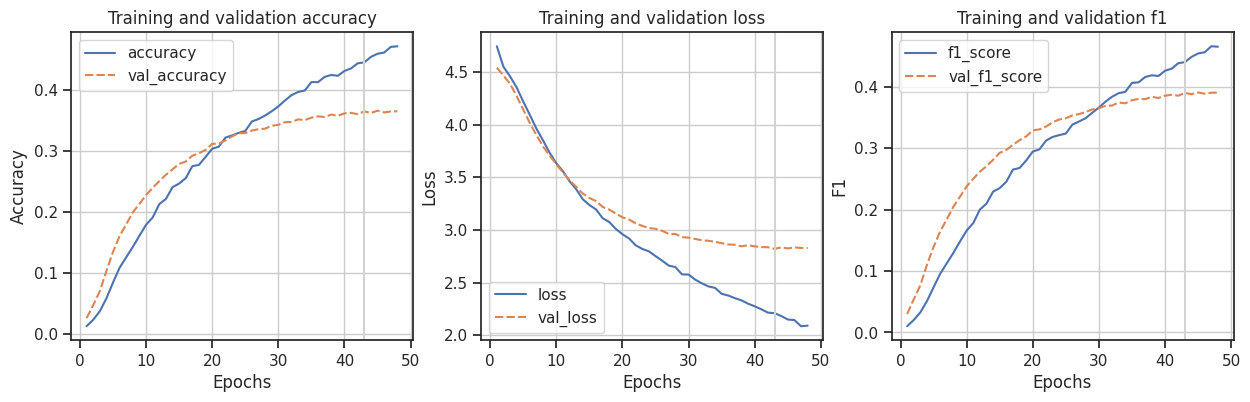

In [ ]:
plot_model_performance(history, axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + '/VGG16_2avgpooling_dropout_batchnorm.h5'))

166/166 [==============================] - 22s 131ms/step - loss: 2.8183 - accuracy: 0.3636 - f1_score: 0.3899

Test loss: 2.818
Test accuracy: 0.364
Test f1: 0.390

Accuracy on test data: 36.36 %
F1-Score on test data: 38.99 %

              precision    recall  f1-score   support

     abhori1       0.30      0.38      0.34        50
     afecuc1       0.39      0.50      0.44        28
     afghor1       0.18      0.30      0.22        20
     afmdov1       0.17      0.40      0.24        15
     afpfly1       0.11      0.13      0.12        31
     afpwag1       0.19      0.38      0.25        24
     afrgos1       0.28      0.50      0.36        24
     afrthr1       0.26      0.43      0.33        30
     amesun2       0.03      0.08      0.04        13
      barswa       0.45      0.23      0.30       166
     bawhor2       0.18      0.27      0.22        15
     bcbeat1       0.09      0.35      0.14        17
     beasun2       0.09      0.33      0.15        12
     bkctch1  

#Fine tuning

## Last layer - Gap

In [ ]:
vgg_ft_1 = tf.keras.models.load_model(os.path.join(MODEL_FOLDER, 'VGG16_2avgpooling_dropout_batchnorm.h5'))

for layer in vgg_ft_1.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

model = compile_model(vgg_ft_1, learning_rate=1e-4)
model.summary()
for i, layer in enumerate(vgg_ft_1.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:
history = run_model(model, 'lastlayer_finetuning_1_gap', train_set, validation_set, MODEL_FOLDER)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 2.3706 - accuracy: 0.4105 - f1_score: 0.4039
Epoch 1: val_loss improved from inf to 2.66924, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/lastlayer_finetuning_1_gap.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 2308s 7s/step - loss: 2.3706 - accuracy: 0.4105 - f1_score: 0.4039 - val_loss: 2.6692 - val_accuracy: 0.3921 - val_f1_score: 0.4148 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 2.1143 - accuracy: 0.4658 - f1_score: 0.4585
Epoch 2: val_loss improved from 2.66924 to 2.59875, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/lastlayer_finetuning_1_gap.h5
313/313 [==============================] - 101s 316ms/step - loss: 2.1143 - accuracy: 0.4658 - f1_score: 0.4585 - val_loss: 2.5988 - val_accuracy: 0.4123 - val_f1_score: 0.4345 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 1.9116 - accuracy: 0.5091 - f1_score: 0.5025
Epoch 3: val_loss improved from 2.59875 to 2.46784, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/lastlayer_finetuning_1_gap.h5
313/313 [==============================] - 101s 320ms/step - loss: 1.9116 - accuracy: 

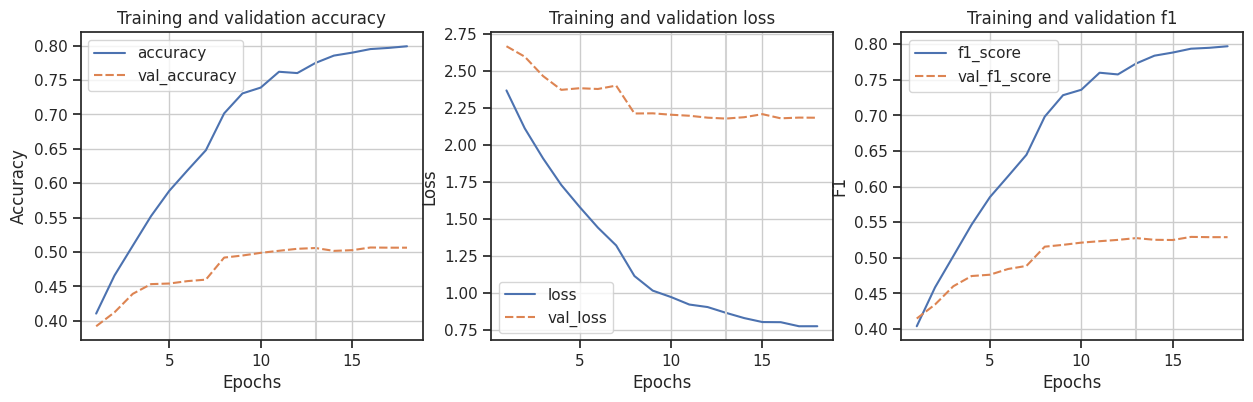

In [ ]:
plot_model_performance(path=os.path.join(MODEL_FOLDER, 'lastlayer_finetuning_1_gap'), axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + '/lastlayer_finetuning_1_gap.h5'))

166/166 [==============================] - 23s 135ms/step - loss: 2.1896 - accuracy: 0.5132 - f1_score: 0.5402

Test loss: 2.190
Test accuracy: 0.513
Test f1: 0.540

Accuracy on test data: 51.32 %
F1-Score on test data: 54.02 %

              precision    recall  f1-score   support

     abhori1       0.45      0.58      0.50        50
     afecuc1       0.63      0.61      0.62        28
     afghor1       0.45      0.50      0.48        20
     afmdov1       0.41      0.60      0.49        15
     afpfly1       0.10      0.16      0.12        31
     afpwag1       0.31      0.54      0.39        24
     afrgos1       0.42      0.58      0.49        24
     afrthr1       0.66      0.77      0.71        30
     amesun2       0.04      0.15      0.06        13
      barswa       0.63      0.40      0.49       166
     bawhor2       0.34      0.73      0.47        15
     bcbeat1       0.15      0.53      0.23        17
     beasun2       0.16      0.42      0.23        12
     bkctch1  

## Last block - Gap

In [ ]:
vgg_ft_1_block = tf.keras.models.load_model(os.path.join(MODEL_FOLDER, 'VGG16_2avgpooling_dropout_batchnorm.h5'))

for layer in vgg_ft_1_block.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3', 'block5_conv2', 'block5_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

model= compile_model(vgg_ft_1_block, learning_rate=1e-4)
model.summary()
for i, layer in enumerate(vgg_ft_1_block.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:
history = run_model(model, 'lastblock_finetuning_1_gap', train_set, validation_set, MODEL_FOLDER)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 2.1811 - accuracy: 0.4558 - f1_score: 0.4495
Epoch 1: val_loss improved from inf to 2.82682, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/lastblock_finetuning_1_gap.h5
313/313 [==============================] - 76s 235ms/step - loss: 2.1811 - accuracy: 0.4558 - f1_score: 0.4495 - val_loss: 2.8268 - val_accuracy: 0.3638 - val_f1_score: 0.3887 - lr: 1.0000e-04


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 2.1430 - accuracy: 0.4630 - f1_score: 0.4581
Epoch 2: val_loss improved from 2.82682 to 2.82402, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/lastblock_finetuning_1_gap.h5
313/313 [==============================] - 74s 234ms/step - loss: 2.1430 - accuracy: 0.4630 - f1_score: 0.4581 - val_loss: 2.8240 - val_accuracy: 0.3679 - val_f1_score: 0.3934 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 2.1408 - accuracy: 0.4573 - f1_score: 0.4525
Epoch 3: val_loss improved from 2.82402 to 2.82212, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/lastblock_finetuning_1_gap.h5
313/313 [==============================] - 74s 236ms/step - loss: 2.1408 - accuracy: 0.4573 - f1_score: 0.4525 - val_loss: 2.8221 - val_accuracy: 0.3648 - val_f1_score: 0.3890 - lr: 1.0000e-04
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 2.0990 - accurac

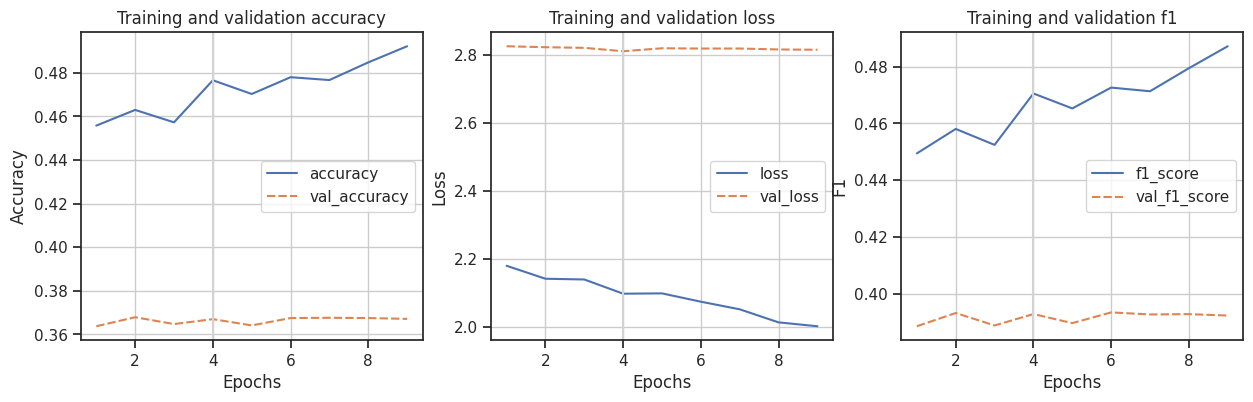

In [ ]:
plot_model_performance(path=os.path.join(MODEL_FOLDER, 'lastblock_finetuning_1_gap'), axis=0)


In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + '/lastblock_finetuning_1_gap.h5'))

166/166 [==============================] - 23s 136ms/step - loss: 2.8044 - accuracy: 0.3685 - f1_score: 0.3952

Test loss: 2.804
Test accuracy: 0.368
Test f1: 0.395

Accuracy on test data: 36.85 %
F1-Score on test data: 39.52 %

              precision    recall  f1-score   support

     abhori1       0.31      0.38      0.34        50
     afecuc1       0.35      0.50      0.41        28
     afghor1       0.19      0.25      0.21        20
     afmdov1       0.15      0.40      0.22        15
     afpfly1       0.10      0.10      0.10        31
     afpwag1       0.24      0.38      0.29        24
     afrgos1       0.34      0.50      0.41        24
     afrthr1       0.25      0.43      0.32        30
     amesun2       0.03      0.08      0.04        13
      barswa       0.52      0.23      0.32       166
     bawhor2       0.24      0.40      0.30        15
     bcbeat1       0.07      0.35      0.12        17
     beasun2       0.10      0.42      0.16        12
     bkctch1  

## Last two blocks - Gap

In [ ]:
vgg_ft_2_block = tf.keras.models.load_model(os.path.join(MODEL_FOLDER, 'VGG16_2avgpooling_dropout_batchnorm.h5'))

for layer in vgg_ft_2_block.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3', 'block5_conv2', 'block5_conv1', 'block4_conv3', 'block4_conv2', 'block5_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

model = compile_model(vgg_ft_2_block, learning_rate=1e-4)

In [ ]:
history = run_model(model, 'lastblock_finetuning_2_gap', train_set, validation_set, MODEL_FOLDER)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 2.1586 - accuracy: 0.4548 - f1_score: 0.4488
Epoch 1: val_loss improved from inf to 2.83783, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/lastblock_finetuning_2_gap.h5
313/313 [==============================] - 77s 239ms/step - loss: 2.1586 - accuracy: 0.4548 - f1_score: 0.4488 - val_loss: 2.8378 - val_accuracy: 0.3638 - val_f1_score: 0.3900 - lr: 1.0000e-04
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 2.1377 - accuracy: 0.4623 - f1_score: 0.4562
Epoch 2: val_loss improved from 2.83783 to 2.83614, saving model to /content/drive/MyDrive/CIDL project/birds/model/ft/lastblock_finetuning_2_gap.h5
313/313 [==============================] - 75s 236ms/step - loss: 2.1377 - accuracy: 0.4623 - f1_score: 0.4562 - val_loss: 2.8361 - val_accuracy: 0.3618 - val_f1_score: 0.3878 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 2.1365 - accuracy: 0.4654 - f1_score: 0.4585
Epoch 3: val_loss did not improve from 2.83614
313/313 [==============================] - 74s 234ms/step - loss: 2.1365 - accuracy: 0.4654 - f1_score: 0.4585 - val_loss: 2.8391 - val_accuracy: 0.3619 - val_f1_score: 0.3878 - lr: 1.0000e-04
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 2.1156 - accuracy: 0.4670 - f1_score: 0.4610
Epoch 4: val_loss improved from 2.83614 to 2.83166, saving model to /content/drive/M

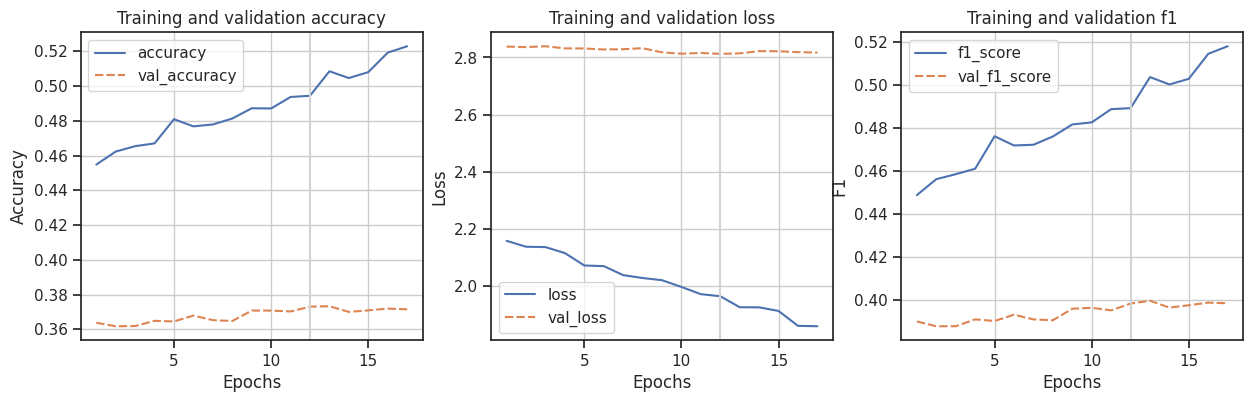

In [ ]:
plot_model_performance(path=os.path.join(MODEL_FOLDER, 'lastblock_finetuning_2_gap'), axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + '/lastblock_finetuning_2_gap.h5'))


166/166 [==============================] - 23s 135ms/step - loss: 2.8099 - accuracy: 0.3726 - f1_score: 0.3983

Test loss: 2.810
Test accuracy: 0.373
Test f1: 0.398

Accuracy on test data: 37.26 %
F1-Score on test data: 39.83 %

              precision    recall  f1-score   support

     abhori1       0.32      0.44      0.37        50
     afecuc1       0.36      0.54      0.43        28
     afghor1       0.24      0.40      0.30        20
     afmdov1       0.13      0.33      0.19        15
     afpfly1       0.16      0.19      0.18        31
     afpwag1       0.20      0.38      0.26        24
     afrgos1       0.31      0.58      0.41        24
     afrthr1       0.29      0.40      0.33        30
     amesun2       0.03      0.08      0.05        13
      barswa       0.49      0.25      0.33       166
     bawhor2       0.21      0.47      0.29        15
     bcbeat1       0.09      0.35      0.14        17
     beasun2       0.11      0.42      0.17        12
     bkctch1  

# Remove block 5

The dataset is small and very different from ImageNet. For this reason, we try to remove the last block that is more specific for the images of the original dataset and may not be suitable for spectrograms images.

Have been repeated the same steps as before.

In [ ]:
def get_index_by_layer_name(model, layer_name):
  '''
  get_index_by_layer_name is used to retrieve the index of a specific layer
  :param model: model to check
  :param layer_name: name of the layer we want to get the index of
  :return: the index of the layer named as defined in layer_name
  '''
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index

In [ ]:
conv_base = tf.keras.applications.VGG16(
    input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),
    include_top= False,
    weights="imagenet",
)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
base = keras.Model(conv_base.input, conv_base.layers[get_index_by_layer_name(conv_base, 'block4_pool')].output, name='base')
base.trainable = False
base.summary()


Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 225, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 225, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 225, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0      

## Feature extraction

###GlobalAveragePooling + BatchNormalization + Dense (256) + Dense (128) + Dropout

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(100, activation="softmax", name='prediction')(x)
model_avgpooling_dropout_dense = keras.Model(inputs, outputs)
model_avgpooling_dropout_dense = compile_model(model_avgpooling_dropout_dense, "adam")
print(model_avgpooling_dropout_dense.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 base (Functional)           (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:
history = run_model(model_avgpooling_dropout_dense, 'VGG16_fe_no5', train_set, validation_set, MODEL_FOLDER)


Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 4.7206 - accuracy: 0.0160 - f1_score: 0.0144
Epoch 1: val_loss improved from inf to 4.49599, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_fe_no5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 86s 246ms/step - loss: 4.7206 - accuracy: 0.0160 - f1_score: 0.0144 - val_loss: 4.4960 - val_accuracy: 0.0427 - val_f1_score: 0.0385 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 4.4471 - accuracy: 0.0430 - f1_score: 0.0377
Epoch 2: val_loss improved from 4.49599 to 4.31808, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_fe_no5.h5
313/313 [==============================] - 71s 224ms/step - loss: 4.4471 - accuracy: 0.0430 - f1_score: 0.0377 - val_loss: 4.3181 - val_accuracy: 0.1002 - val_f1_score: 0.1025 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 4.2881 - accuracy: 0.0762 - f1_score: 0.0653
Epoch 3: val_loss improved from 4.31808 to 4.11838, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_fe_no5.h5
313/313 [==============================] - 70s 223ms/step - loss: 4.2881 - accuracy: 0.0762 - f1_score: 0.06

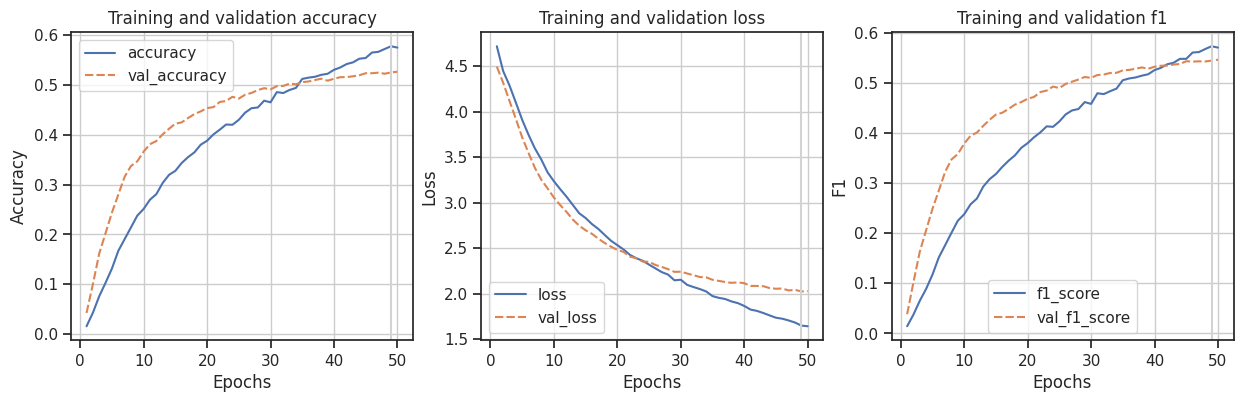

In [ ]:
plot_model_performance(history, axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + '/VGG16_fe_no5.h5'))

166/166 [==============================] - 22s 129ms/step - loss: 2.0777 - accuracy: 0.5215 - f1_score: 0.5441

Test loss: 2.078
Test accuracy: 0.521
Test f1: 0.544

Accuracy on test data: 52.15 %
F1-Score on test data: 54.41 %

              precision    recall  f1-score   support

     abhori1       0.37      0.58      0.45        50
     afecuc1       0.84      0.75      0.79        28
     afghor1       0.52      0.55      0.54        20
     afmdov1       0.39      0.80      0.52        15
     afpfly1       0.13      0.16      0.14        31
     afpwag1       0.38      0.62      0.48        24
     afrgos1       0.36      0.67      0.46        24
     afrthr1       0.42      0.70      0.53        30
     amesun2       0.10      0.15      0.12        13
      barswa       0.54      0.45      0.49       166
     bawhor2       0.20      0.53      0.29        15
     bcbeat1       0.21      0.88      0.34        17
     beasun2       0.21      0.42      0.28        12
     bkctch1  

###GlobalAveragePooling + BatchNormalization + Dense (256) + Dropout

In [ ]:
inputs = keras.Input(shape=(224,224,3))
# inputs = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(100, activation="softmax", name='prediction')(x)
model_avgpooling_dropout_dense = keras.Model(inputs, outputs)
model_avgpooling_dropout_dense = compile_model(model_avgpooling_dropout_dense, "adam")
print(model_avgpooling_dropout_dense.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 base (Functional)           (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

In [ ]:
history = run_model(model_avgpooling_dropout_dense, 'VGG16_fe2_no5', train_set, validation_set, MODEL_FOLDER)


Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 4.9961 - accuracy: 0.0204 - f1_score: 0.0187
Epoch 1: val_loss improved from inf to 4.34491, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_fe2_no5.h5
313/313 [==============================] - 72s 222ms/step - loss: 4.9961 - accuracy: 0.0204 - f1_score: 0.0187 - val_loss: 4.3449 - val_accuracy: 0.0701 - val_f1_score: 0.0761 - lr: 1.0000e-04
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 4.4207 - accuracy: 0.0610 - f1_score: 0.0576
Epoch 2: val_loss improved from 4.34491 to 3.99416, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_fe2_no5.h5
313/313 [==============================] - 70s 223ms/step - loss: 4.4207 - accuracy: 0.0610 - f1_score: 0.0576 - val_loss: 3.9942 - val_accuracy: 0.1494 - val_f1_score: 0.1594 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 4.1018 - accuracy: 0.1008 - f1_score: 0.0942
Epoch 3: val_loss improved from 3.99416 to 3.74677, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_fe2_no5.h5
313/313 [==============================] - 70s 223ms/step - loss: 4.1018 - accuracy: 0.1008 - f1_score: 0.0942 - val_loss: 3.7468 - val_accuracy: 0.2136 - val_f1_score: 0.2255 - lr: 1.0000e-04
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 3.8603 - accuracy: 0.1386 - f1_score: 0.1296
Ep

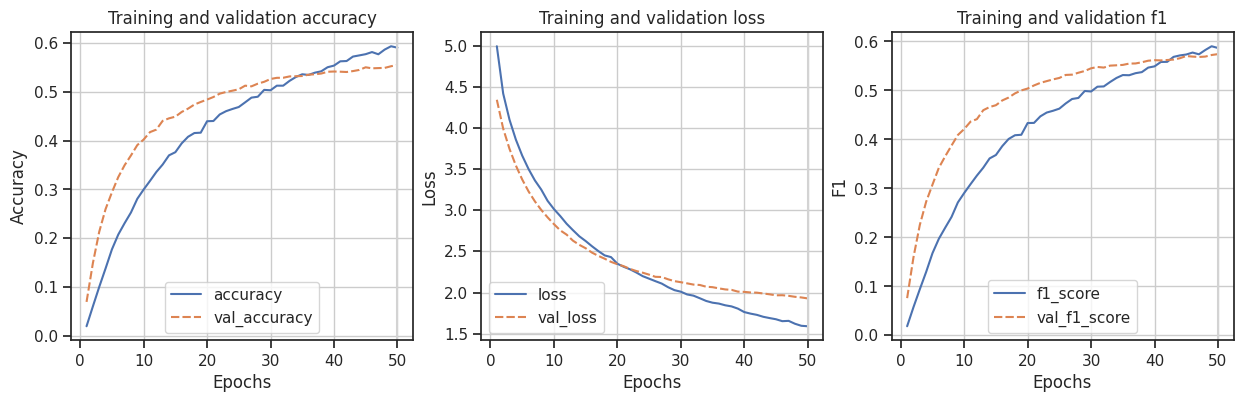

In [ ]:
plot_model_performance(history, axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + '/VGG16_fe2_no5.h5'))

166/166 [==============================] - 22s 129ms/step - loss: 1.9798 - accuracy: 0.5492 - f1_score: 0.5700

Test loss: 1.980
Test accuracy: 0.549
Test f1: 0.570

Accuracy on test data: 54.92 %
F1-Score on test data: 57.00 %

              precision    recall  f1-score   support

     abhori1       0.47      0.56      0.51        50
     afecuc1       0.78      0.75      0.76        28
     afghor1       0.44      0.55      0.49        20
     afmdov1       0.44      0.80      0.57        15
     afpfly1       0.15      0.16      0.15        31
     afpwag1       0.29      0.50      0.37        24
     afrgos1       0.38      0.71      0.49        24
     afrthr1       0.52      0.77      0.62        30
     amesun2       0.08      0.15      0.11        13
      barswa       0.70      0.42      0.52       166
     bawhor2       0.28      0.73      0.40        15
     bcbeat1       0.20      0.82      0.33        17
     beasun2       0.30      0.58      0.40        12
     bkctch1  

###GlobalAveragePooling + Dense (256)

In [ ]:
inputs = keras.Input(shape=(224,224,3))
# inputs = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(100, activation="softmax", name='prediction')(x)
model_avgpooling_dropout_dense = keras.Model(inputs, outputs)
model_avgpooling_dropout_dense = compile_model(model_avgpooling_dropout_dense, "adam")
print(model_avgpooling_dropout_dense.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 base (Functional)           (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

In [ ]:
history = run_model(model_avgpooling_dropout_dense, 'VGG16_fe3_no5', train_set, validation_set, MODEL_FOLDER)


Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 30.2508 - accuracy: 0.0156 - f1_score: 0.0153
Epoch 1: val_loss improved from inf to 17.74109, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_fe3_no5.h5
313/313 [==============================] - 71s 222ms/step - loss: 30.2508 - accuracy: 0.0156 - f1_score: 0.0153 - val_loss: 17.7411 - val_accuracy: 0.0205 - val_f1_score: 0.0211 - lr: 1.0000e-04
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 14.6408 - accuracy: 0.0310 - f1_score: 0.0310
Epoch 2: val_loss improved from 17.74109 to 13.02423, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_fe3_no5.h5
313/313 [==============================] - 70s 223ms/step - loss: 14.6408 - accuracy: 0.0310 - f1_score: 0.0310 - val_loss: 13.0242 - val_accuracy: 0.0308 - val_f1_score: 0.0342 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 11.5146 - accuracy: 0.0504 - f1_score: 0.0503
Epoch 3: val_loss improved from 13.02423 to 10.91809, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_fe3_no5.h5
313/313 [==============================] - 72s 228ms/step - loss: 11.5146 - accuracy: 0.0504 - f1_score: 0.0503 - val_loss: 10.9181 - val_accuracy: 0.0476 - val_f1_score: 0.0525 - lr: 1.0000e-04
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 9.7741 - accuracy: 0.0738 - f1_score:

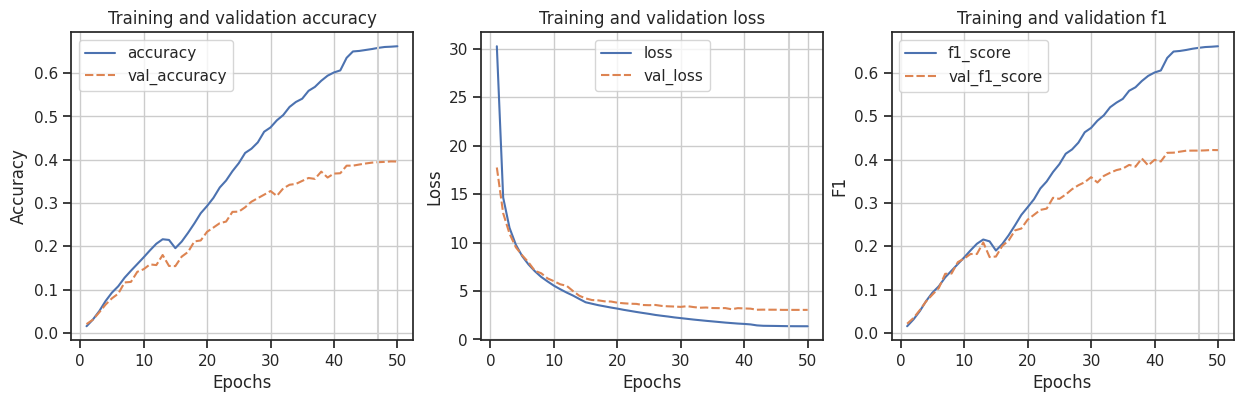

In [ ]:
plot_model_performance(history, axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + '/VGG16_fe3_no5.h5'))

166/166 [==============================] - 22s 131ms/step - loss: 3.1526 - accuracy: 0.3771 - f1_score: 0.4075

Test loss: 3.153
Test accuracy: 0.377
Test f1: 0.407

Accuracy on test data: 37.71 %
F1-Score on test data: 40.75 %

              precision    recall  f1-score   support

     abhori1       0.38      0.40      0.39        50
     afecuc1       0.37      0.39      0.38        28
     afghor1       0.28      0.40      0.33        20
     afmdov1       0.23      0.47      0.30        15
     afpfly1       0.05      0.10      0.07        31
     afpwag1       0.14      0.29      0.19        24
     afrgos1       0.37      0.54      0.44        24
     afrthr1       0.33      0.60      0.42        30
     amesun2       0.02      0.08      0.04        13
      barswa       0.54      0.33      0.41       166
     bawhor2       0.32      0.80      0.46        15
     bcbeat1       0.11      0.29      0.16        17
     beasun2       0.14      0.42      0.20        12
     bkctch1  

## Fine tuning

### Last block

In [ ]:
vgg_ft_1_block = tf.keras.models.load_model(os.path.join(MODEL_FOLDER, 'VGG16_fe2_no5.h5'))

for layer in vgg_ft_1_block.get_layer('base').layers:
    if layer.name in ('block4_conv3', 'block4_conv2', 'block4_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

model = compile_model(vgg_ft_1_block, learning_rate=1e-4)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 base (Functional)           (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

In [ ]:
history = run_model(model, 'VGG16_2ft_lastblock', train_set, validation_set, MODEL_FOLDER)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 2.1493 - accuracy: 0.4702 - f1_score: 0.4666
Epoch 1: val_loss improved from inf to 3.12220, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_2ft_lastblock.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 88s 266ms/step - loss: 2.1493 - accuracy: 0.4702 - f1_score: 0.4666 - val_loss: 3.1222 - val_accuracy: 0.3737 - val_f1_score: 0.3965 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 1.7432 - accuracy: 0.5545 - f1_score: 0.5517
Epoch 2: val_loss improved from 3.12220 to 2.44562, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_2ft_lastblock.h5
313/313 [==============================] - 97s 307ms/step - loss: 1.7432 - accuracy: 0.5545 - f1_score: 0.5517 - val_loss: 2.4456 - val_accuracy: 0.4557 - val_f1_score: 0.4766 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 1.4933 - accuracy: 0.6127 - f1_score: 0.6105
Epoch 3: val_loss improved from 2.44562 to 2.17522, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_2ft_lastblock.h5
313/313 [==============================] - 88s 278ms/step - loss: 1.4933 - accuracy: 0.6127 - 

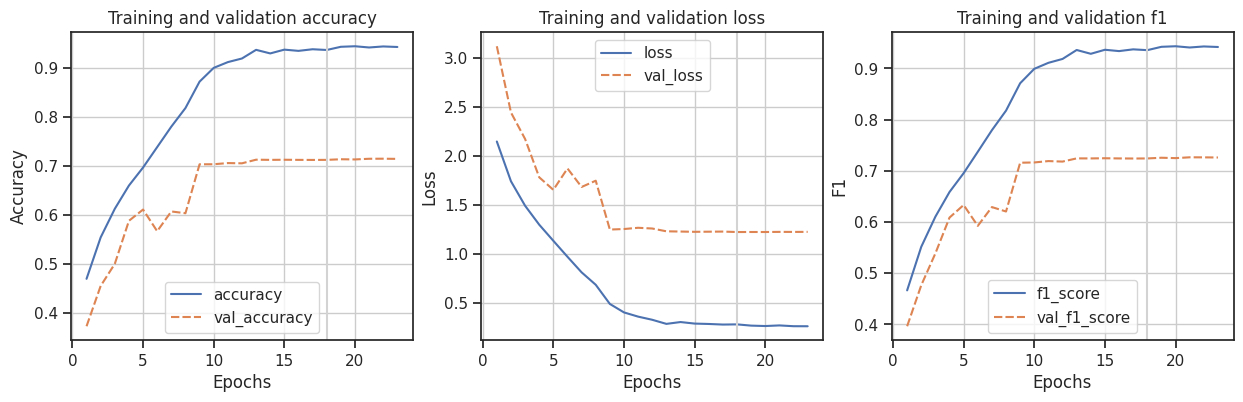

In [ ]:
plot_model_performance(path=os.path.join(MODEL_FOLDER, 'VGG16_2ft_lastblock'), axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + '/VGG16_2ft_lastblock.h5'))


166/166 [==============================] - 22s 129ms/step - loss: 1.2570 - accuracy: 0.7111 - f1_score: 0.7254

Test loss: 1.257
Test accuracy: 0.711
Test f1: 0.725

Accuracy on test data: 71.11 %
F1-Score on test data: 72.54 %

              precision    recall  f1-score   support

     abhori1       0.76      0.76      0.76        50
     afecuc1       0.92      0.86      0.89        28
     afghor1       0.54      0.75      0.63        20
     afmdov1       0.68      0.87      0.76        15
     afpfly1       0.27      0.39      0.32        31
     afpwag1       0.55      0.75      0.63        24
     afrgos1       0.55      0.67      0.60        24
     afrthr1       0.71      0.73      0.72        30
     amesun2       0.04      0.08      0.05        13
      barswa       0.77      0.66      0.71       166
     bawhor2       0.45      0.87      0.59        15
     bcbeat1       0.28      1.00      0.44        17
     beasun2       0.43      0.83      0.57        12
     bkctch1  

### Last two blocks

In [ ]:
vgg_ft_2_block = tf.keras.models.load_model(os.path.join(MODEL_FOLDER, 'VGG16_fe2_no5.h5'))

for layer in vgg_ft_2_block.get_layer('base').layers:
    if layer.name in ('block4_conv3', 'block4_conv1', 'block4_conv2', 'block3_conv3' , 'block3_conv2' , 'block3_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

model = compile_model(vgg_ft_2_block, learning_rate=1e-4)
model.summary()
for i, layer in enumerate(vgg_ft_2_block.get_layer('base').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 base (Functional)           (None, 14, 14, 512)       7635264   
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

In [ ]:
history = run_model(model, 'VGG16_2ft_twoblocks', train_set, validation_set, MODEL_FOLDER)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 2.2915 - accuracy: 0.4357 - f1_score: 0.4327
Epoch 1: val_loss improved from inf to 2.84614, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_2ft_twoblocks.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 2259s 7s/step - loss: 2.2915 - accuracy: 0.4357 - f1_score: 0.4327 - val_loss: 2.8461 - val_accuracy: 0.3657 - val_f1_score: 0.4172 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 1.8647 - accuracy: 0.5313 - f1_score: 0.5283
Epoch 2: val_loss improved from 2.84614 to 2.24927, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_2ft_twoblocks.h5
313/313 [==============================] - 138s 435ms/step - loss: 1.8647 - accuracy: 0.5313 - f1_score: 0.5283 - val_loss: 2.2493 - val_accuracy: 0.4770 - val_f1_score: 0.5115 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 1.6105 - accuracy: 0.5906 - f1_score: 0.5882
Epoch 3: val_loss improved from 2.24927 to 2.14084, saving model to /content/drive/MyDrive/CIDL project/birds/model/VGG16/VGG16_2ft_twoblocks.h5
313/313 [==============================] - 137s 434ms/step - loss: 1.6105 - accuracy: 0.5906 -

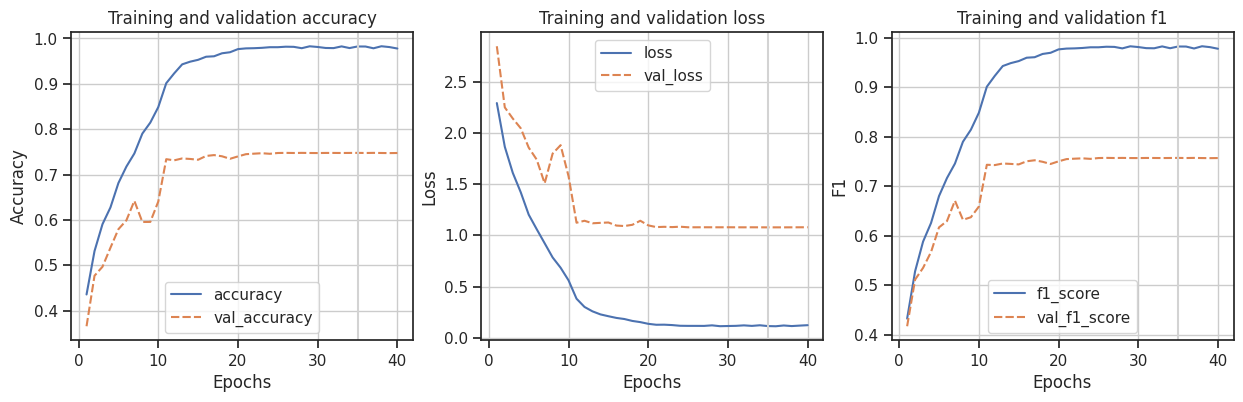

In [ ]:
plot_model_performance(path=os.path.join(MODEL_FOLDER, 'VGG16_2ft_twoblocks'), axis=0)

In [ ]:
evaluate_model(tf.keras.models.load_model(MODEL_FOLDER + '/VGG16_2ft_twoblocks.h5'))


166/166 [==============================] - 1451s 9s/step - loss: 1.1389 - accuracy: 0.7401 - f1_score: 0.7524

Test loss: 1.139
Test accuracy: 0.740
Test f1: 0.752

Accuracy on test data: 74.01 %
F1-Score on test data: 75.24 %

              precision    recall  f1-score   support

     abhori1       0.80      0.80      0.80        50
     afecuc1       1.00      0.89      0.94        28
     afghor1       0.62      0.75      0.68        20
     afmdov1       0.70      0.93      0.80        15
     afpfly1       0.29      0.52      0.37        31
     afpwag1       0.56      0.83      0.67        24
     afrgos1       0.86      0.75      0.80        24
     afrthr1       0.70      0.77      0.73        30
     amesun2       0.15      0.38      0.21        13
      barswa       0.76      0.64      0.70       166
     bawhor2       0.45      0.93      0.61        15
     bcbeat1       0.31      1.00      0.47        17
     beasun2       0.38      0.67      0.48        12
     bkctch1   